In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
import itertools
import scipy.stats as stats
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from warnings import filterwarnings
filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

In [2]:
df = pd.read_csv('Rose.csv')

In [3]:
df.head()

,YearMonth,Rose
0,1980-01,112.0
1,1980-02,118.0
2,1980-03,129.0
3,1980-04,99.0
4,1980-05,116.0


In [4]:
date = pd.date_range(start='1/1/1980', end='8/1/1995', freq='M')
date

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '1994-10-31', '1994-11-30', '1994-12-31', '1995-01-31',
               '1995-02-28', '1995-03-31', '1995-04-30', '1995-05-31',
               '1995-06-30', '1995-07-31'],
              dtype='datetime64[ns]', length=187, freq='M')

In [5]:
df = pd.DataFrame({'YearMonth':date,
                   'Rose':df['Rose']})
df.set_index('YearMonth',inplace=True)

In [6]:
df.head()

,Rose
YearMonth,
1980-01-31,112.0
1980-02-29,118.0
1980-03-31,129.0
1980-04-30,99.0
1980-05-31,116.0


In [7]:
df.tail()

,Rose
YearMonth,
1995-03-31,45.0
1995-04-30,52.0
1995-05-31,28.0
1995-06-30,40.0
1995-07-31,62.0


In [8]:
df.shape

(187, 1)

In [9]:
df.isnull().sum()

Rose    2
dtype: int64

In [10]:
df[df['Rose'].isna()]

,Rose
YearMonth,
1994-07-31,NaN
1994-08-31,NaN


In [11]:
df['1994']

,Rose
YearMonth,
1994-01-31,30.0
1994-02-28,35.0
1994-03-31,42.0
1994-04-30,48.0
1994-05-31,44.0
1994-06-30,45.0
1994-07-31,NaN
1994-08-31,NaN
1994-09-30,46.0


In [12]:
# Missing value replacement

df = df.interpolate(method = 'pad')

In [13]:
df['1994']

,Rose
YearMonth,
1994-01-31,30.0
1994-02-28,35.0
1994-03-31,42.0
1994-04-30,48.0
1994-05-31,44.0
1994-06-30,45.0
1994-07-31,45.0
1994-08-31,45.0
1994-09-30,46.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-31 to 1995-07-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rose    187 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


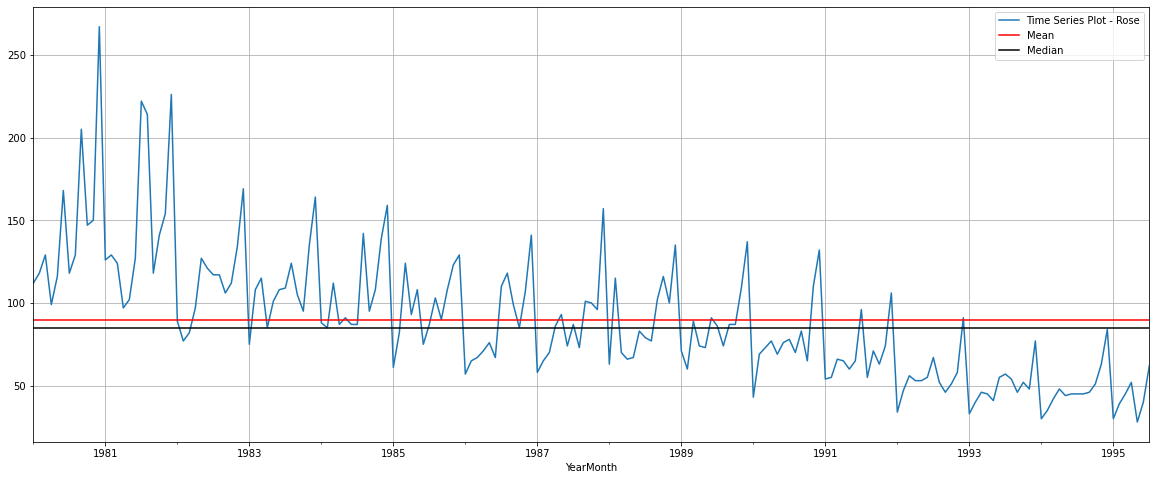

In [15]:
rcParams['figure.figsize'] = 20,8
df.plot();
plt.axhline(df['Rose'].mean(), color='Red');
plt.axhline(df['Rose'].median(), color='black');
plt.grid();
plt.legend(['Time Series Plot - Rose', 'Mean', 'Median']);

In [16]:
round(df.describe(),3)

,Rose
count,187.000
mean,89.909
std,39.244
min,28.000
25%,62.500
50%,85.000
75%,111.000
max,267.000


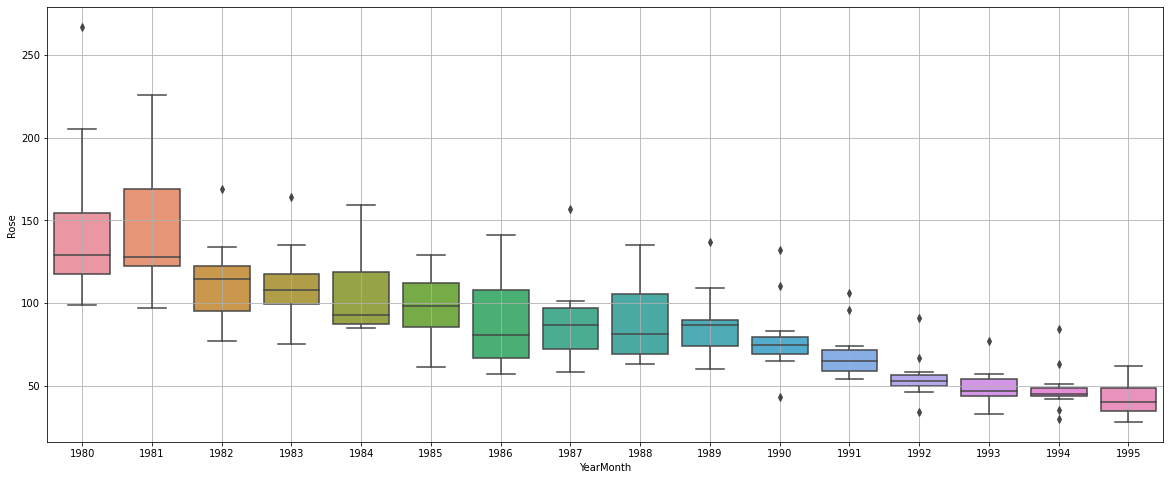

In [17]:
sns.boxplot(x = df.index.year,y = df['Rose'])
plt.grid();

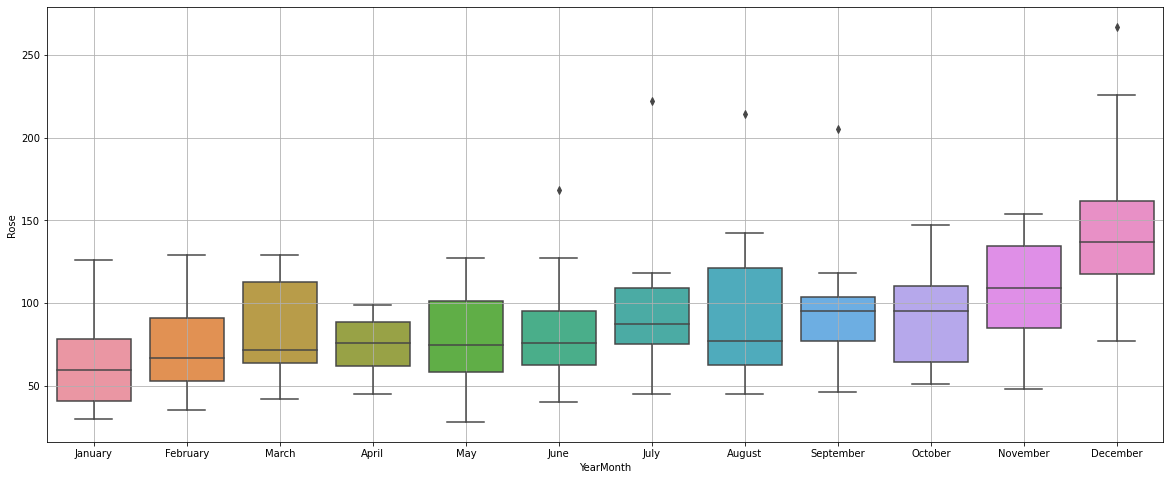

In [18]:
sns.boxplot(x = df.index.month_name(),y = df['Rose'])
plt.grid();

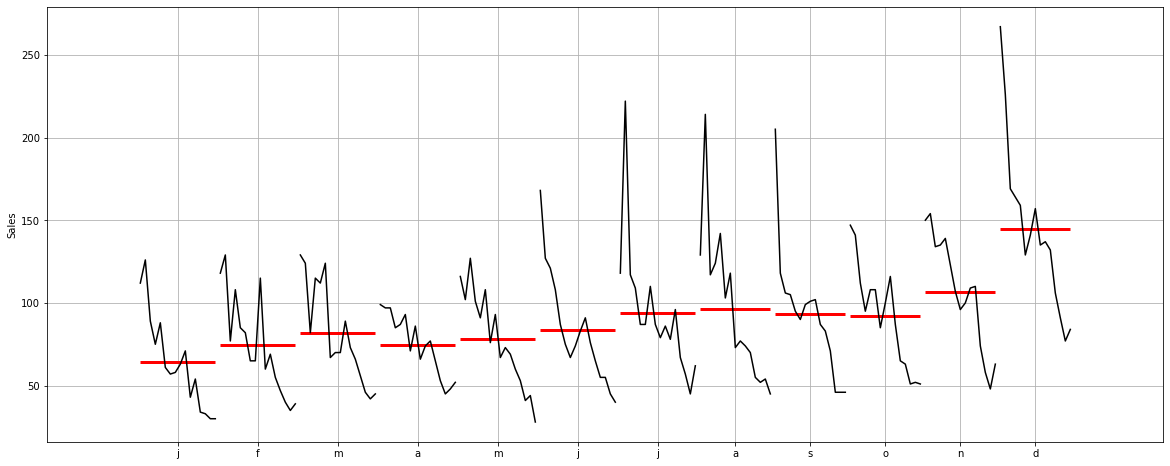

In [19]:
from statsmodels.graphics.tsaplots import month_plot

month_plot(df['Rose'],ylabel='Sales')
plt.grid();

In [20]:
monthly_sales_across_years = pd.pivot_table(df, values = 'Rose', columns = df.index.month, index = df.index.year)
monthly_sales_across_years

YearMonth,1,2,3,4,5,6,7,8,9,10,11,12
YearMonth,,,,,,,,,,,,
1980,112.0,118.0,129.0,99.0,116.0,168.0,118.0,129.0,205.0,147.0,150.0,267.0
1981,126.0,129.0,124.0,97.0,102.0,127.0,222.0,214.0,118.0,141.0,154.0,226.0
1982,89.0,77.0,82.0,97.0,127.0,121.0,117.0,117.0,106.0,112.0,134.0,169.0
1983,75.0,108.0,115.0,85.0,101.0,108.0,109.0,124.0,105.0,95.0,135.0,164.0
1984,88.0,85.0,112.0,87.0,91.0,87.0,87.0,142.0,95.0,108.0,139.0,159.0
1985,61.0,82.0,124.0,93.0,108.0,75.0,87.0,103.0,90.0,108.0,123.0,129.0
1986,57.0,65.0,67.0,71.0,76.0,67.0,110.0,118.0,99.0,85.0,107.0,141.0
1987,58.0,65.0,70.0,86.0,93.0,74.0,87.0,73.0,101.0,100.0,96.0,157.0
1988,63.0,115.0,70.0,66.0,67.0,83.0,79.0,77.0,102.0,116.0,100.0,135.0


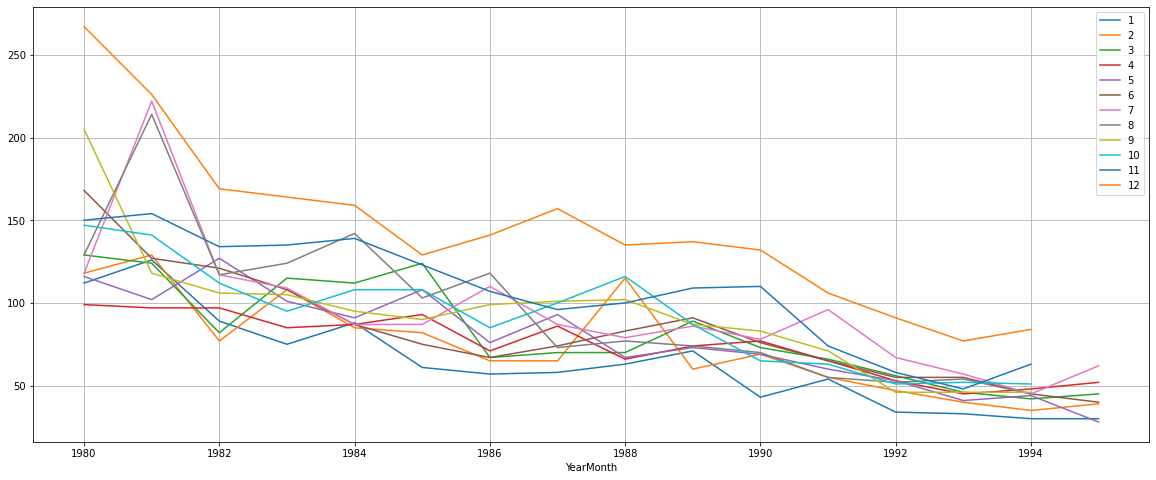

In [21]:
monthly_sales_across_years.plot()
plt.grid()
plt.legend(loc='best');

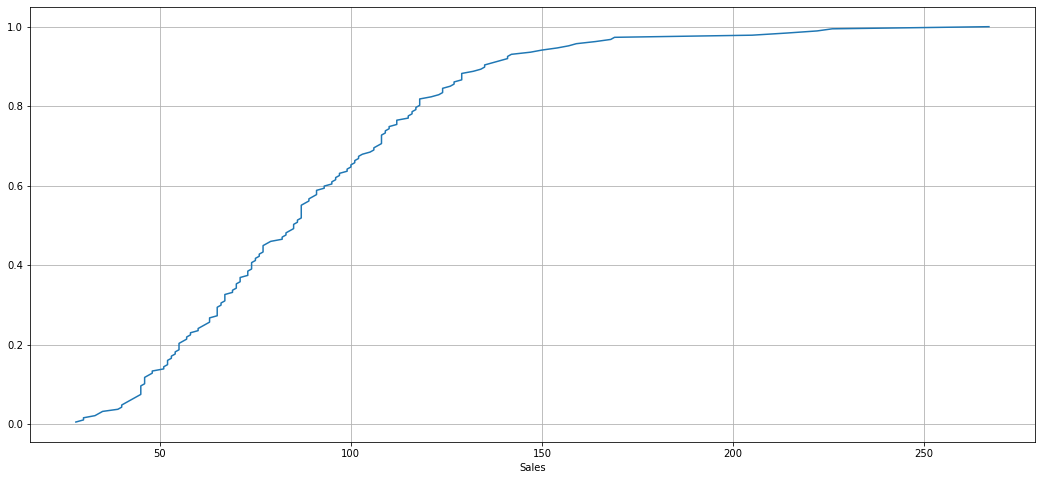

In [22]:
# ECD plot helps to understand the statstical distribution in the time series.i.e percentage distribution
# This particular graph tells us what percentage of data points refer to what number of Sales.

from statsmodels.distributions.empirical_distribution import ECDF

plt.figure(figsize = (18, 8))
cdf = ECDF(df['Rose'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.grid()
plt.xlabel('Sales');

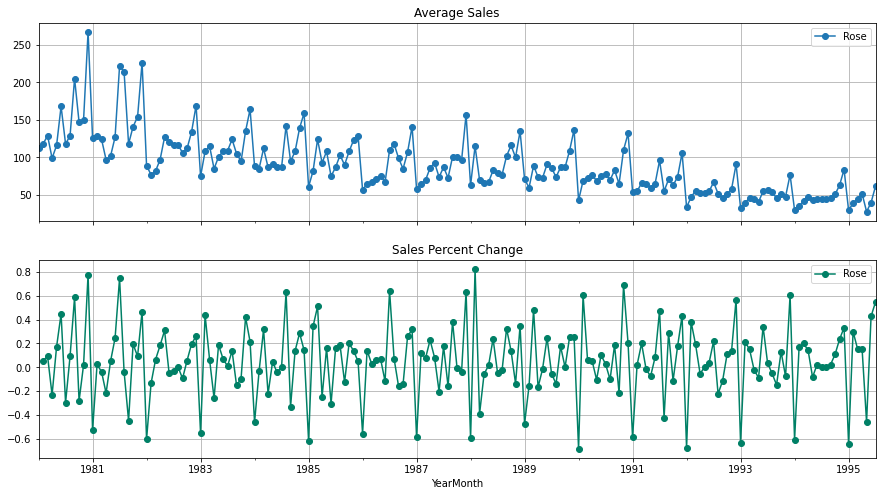

In [23]:
# group by date and get average RetailSales, and precent change
# We are trying to find the mean sales month on month and percentage change ( time 2- time 1)/(time 1)
average    = df.groupby(df.index)['Rose'].mean()
pct_change = df.groupby(df.index)['Rose'].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average RetailSales over time(year-month)
ax1 = average.plot(legend=True,ax=axis1,marker='o',title="Average Sales",grid=True)
ax1.set_xticks(range(len(average)))
ax1.set_xticklabels(average.index.tolist())
# plot precent change for RetailSales over time(year-month)
ax2 = pct_change.plot(legend=True,ax=axis2,marker='o',colormap="summer",title="Sales Percent Change",grid=True)

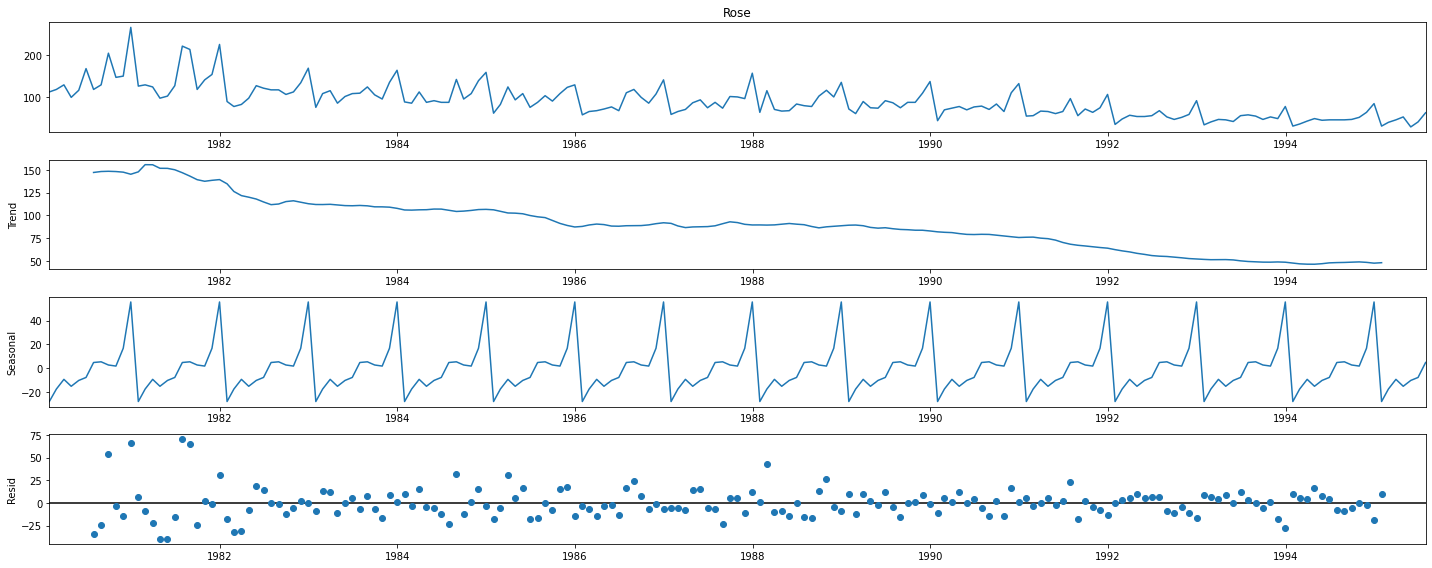

In [24]:
# Additive Decomposition
decomp_additive = seasonal_decompose(df['Rose'],model='additive')
decomp_additive.plot();

In [25]:
trend_add = decomp_additive.trend
seasonality_add = decomp_additive.seasonal
residual_add = decomp_additive.resid

print('Trend','\n',trend_add.head(12),'\n')
print('Seasonality','\n',seasonality_add.head(12),'\n')
print('Residual','\n',residual_add.head(12),'\n')

Trend 
 YearMonth
1980-01-31           NaN
1980-02-29           NaN
1980-03-31           NaN
1980-04-30           NaN
1980-05-31           NaN
1980-06-30           NaN
1980-07-31    147.083333
1980-08-31    148.125000
1980-09-30    148.375000
1980-10-31    148.083333
1980-11-30    147.416667
1980-12-31    145.125000
Name: trend, dtype: float64 

Seasonality 
 YearMonth
1980-01-31   -27.903092
1980-02-29   -17.431663
1980-03-31    -9.279878
1980-04-30   -15.092378
1980-05-31   -10.190592
1980-06-30    -7.672735
1980-07-31     4.880241
1980-08-31     5.460797
1980-09-30     2.780241
1980-10-31     1.877464
1980-11-30    16.852464
1980-12-31    55.719130
Name: seasonal, dtype: float64 

Residual 
 YearMonth
1980-01-31          NaN
1980-02-29          NaN
1980-03-31          NaN
1980-04-30          NaN
1980-05-31          NaN
1980-06-30          NaN
1980-07-31   -33.963575
1980-08-31   -24.585797
1980-09-30    53.844759
1980-10-31    -2.960797
1980-11-30   -14.269130
1980-12-31    66.15587

In [26]:
residual_add.mean()

-0.08024140211639655

<AxesSubplot:xlabel='resid', ylabel='Density'>

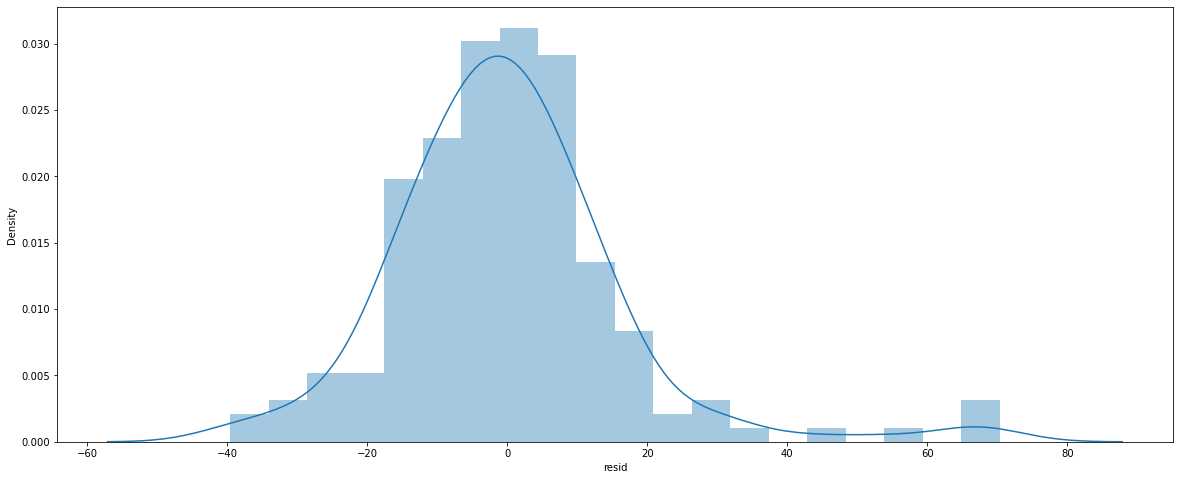

In [27]:
sns.distplot(residual_add)

In [28]:
# p is not significant so we reject H0, meaning residuals are not normally distributed

stats.shapiro(residual_add.dropna())

ShapiroResult(statistic=0.9108030796051025, pvalue=8.016915131747737e-09)

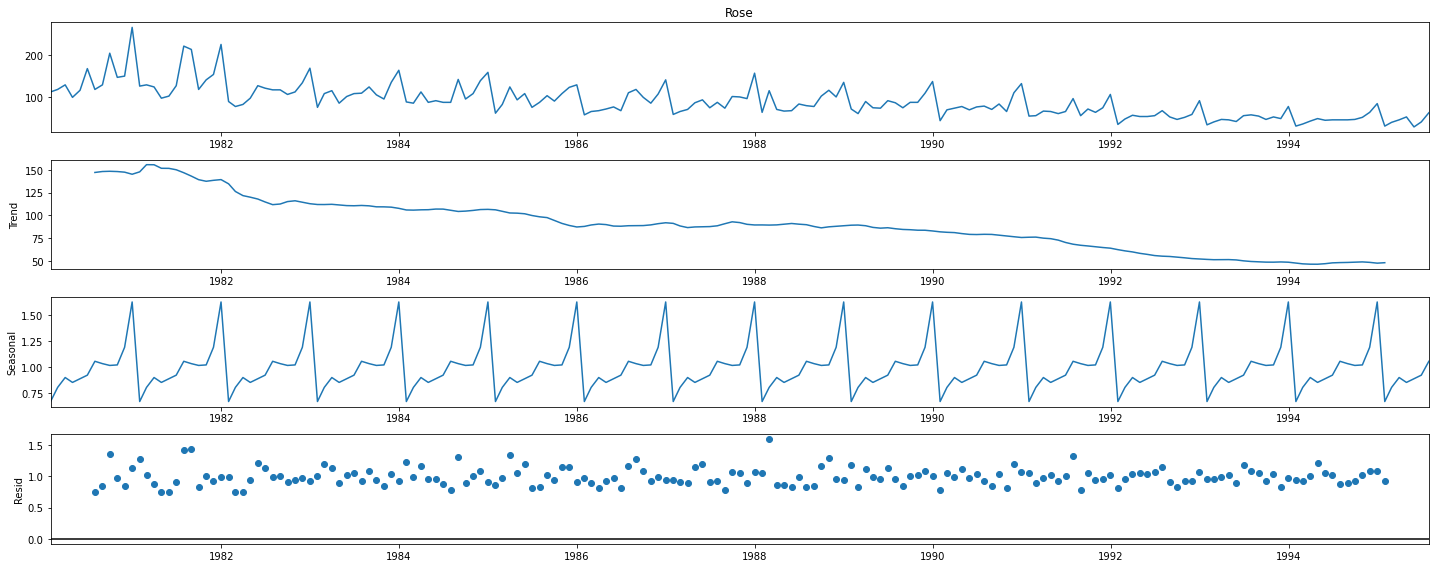

In [29]:
decomp_multiplicative = seasonal_decompose(df['Rose'],model='multiplicative')
decomp_multiplicative.plot();

In [30]:
trend_mul = decomp_multiplicative.trend
seasonality_mul = decomp_multiplicative.seasonal
residual_mul = decomp_multiplicative.resid

print('Trend','\n',trend_mul.head(12),'\n')
print('Seasonality','\n',seasonality_mul.head(12),'\n')
print('Residual','\n',residual_mul.head(12),'\n')

Trend 
 YearMonth
1980-01-31           NaN
1980-02-29           NaN
1980-03-31           NaN
1980-04-30           NaN
1980-05-31           NaN
1980-06-30           NaN
1980-07-31    147.083333
1980-08-31    148.125000
1980-09-30    148.375000
1980-10-31    148.083333
1980-11-30    147.416667
1980-12-31    145.125000
Name: trend, dtype: float64 

Seasonality 
 YearMonth
1980-01-31    0.670182
1980-02-29    0.806224
1980-03-31    0.901278
1980-04-30    0.854154
1980-05-31    0.889531
1980-06-30    0.924099
1980-07-31    1.057682
1980-08-31    1.035066
1980-09-30    1.017753
1980-10-31    1.022688
1980-11-30    1.192494
1980-12-31    1.628848
Name: seasonal, dtype: float64 

Residual 
 YearMonth
1980-01-31         NaN
1980-02-29         NaN
1980-03-31         NaN
1980-04-30         NaN
1980-05-31         NaN
1980-06-30         NaN
1980-07-31    0.758514
1980-08-31    0.841382
1980-09-30    1.357534
1980-10-31    0.970661
1980-11-30    0.853274
1980-12-31    1.129506
Name: resid, dtype: fl

In [31]:
residual_mul.mean()

0.9994626392539752

<AxesSubplot:xlabel='resid', ylabel='Density'>

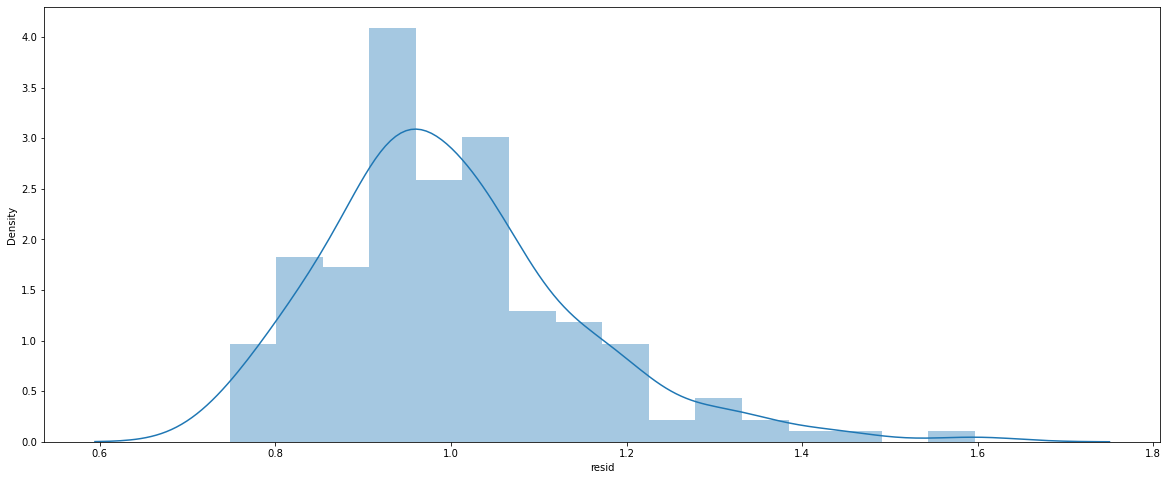

In [32]:
sns.distplot(residual_mul)

In [33]:
# p is not significant so we reject H0, meaning residuals are not normally distributed

stats.shapiro(residual_mul.dropna())

ShapiroResult(statistic=0.9490888118743896, pvalue=6.251284503377974e-06)

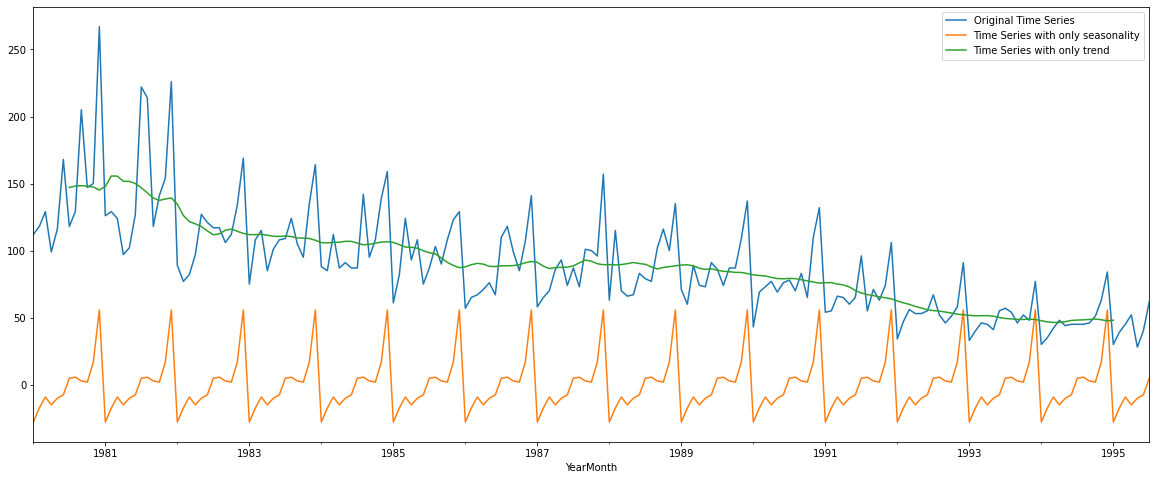

In [34]:
# Taking additive model
df.plot()
seasonality_add.plot();
trend_add.plot();
plt.legend(["Original Time Series", "Time Series with only seasonality", "Time Series with only trend"]);

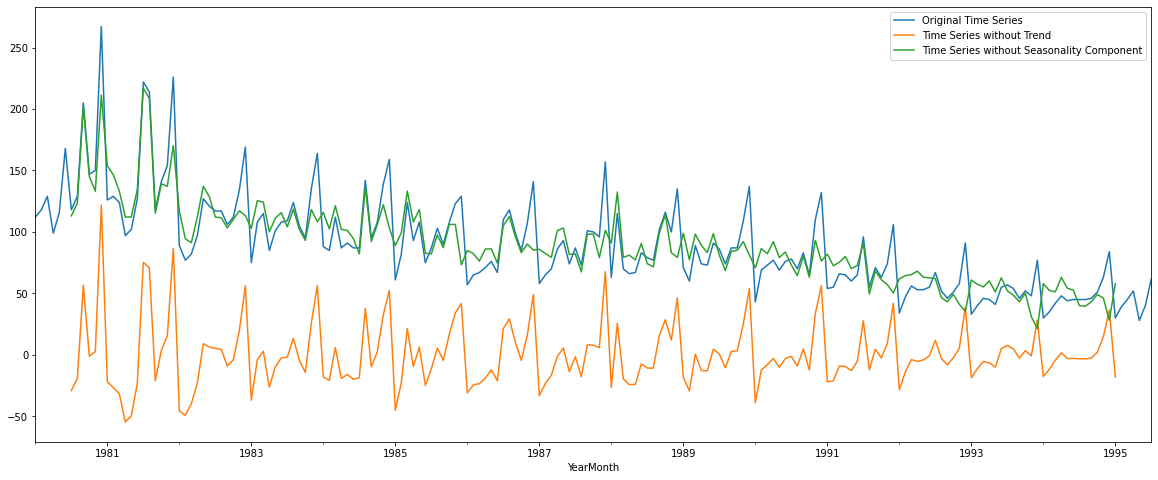

In [35]:
deseasonal_ts = trend_add + residual_add
detrend_ts = seasonality_add + residual_add
df.plot()
detrend_ts.plot()
deseasonal_ts.plot()
plt.legend(["Original Time Series", "Time Series without Trend", "Time Series without Seasonality Component"]);

In [36]:
# Note - Seasonality is multiplicative as residual curve is more flat in this model
# For trend it is a decilne one

In [37]:
train = df[df.index.year < 1991]
test = df[df.index.year >= 1991]

In [38]:
print(train.shape)
print(test.shape)

(132, 1)
(55, 1)


In [39]:
train.head()

,Rose
YearMonth,
1980-01-31,112.0
1980-02-29,118.0
1980-03-31,129.0
1980-04-30,99.0
1980-05-31,116.0


In [40]:
train.tail()

,Rose
YearMonth,
1990-08-31,70.0
1990-09-30,83.0
1990-10-31,65.0
1990-11-30,110.0
1990-12-31,132.0


In [41]:
test.head()

,Rose
YearMonth,
1991-01-31,54.0
1991-02-28,55.0
1991-03-31,66.0
1991-04-30,65.0
1991-05-31,60.0


In [42]:
test.tail()

,Rose
YearMonth,
1995-03-31,45.0
1995-04-30,52.0
1995-05-31,28.0
1995-06-30,40.0
1995-07-31,62.0


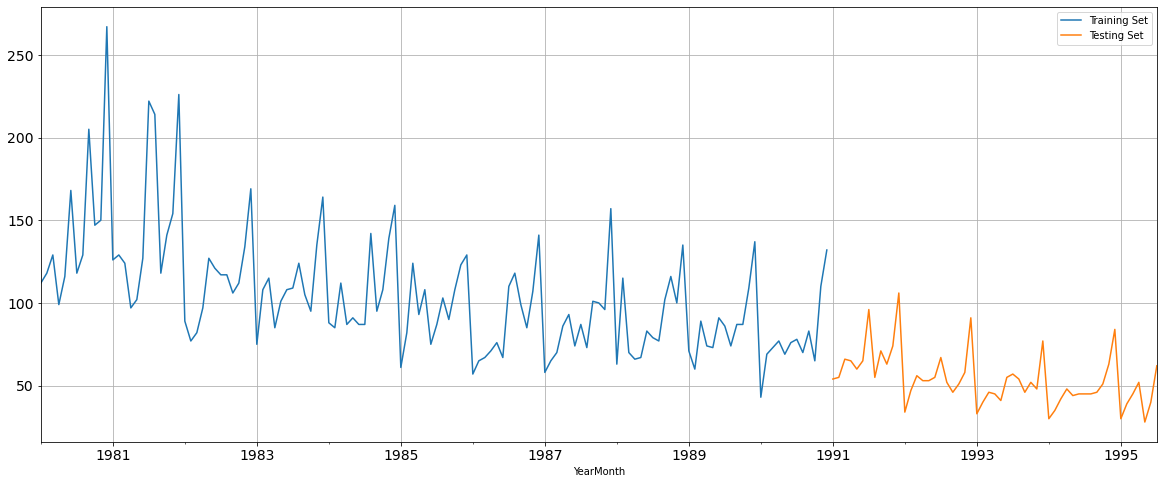

In [43]:
train['Rose'].plot(fontsize = 14)
test['Rose'].plot(fontsize = 14)
plt.grid()
plt.legend(['Training Set', 'Testing Set'])
plt.show()

In [44]:
# Model  1 - Linear Regression

In [45]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+133 for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
Test Time instance 
 [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


In [46]:
lr_train = train.copy()
lr_test = test.copy()

In [47]:
lr_train['time'] = train_time
lr_test['time'] = test_time

print('First few rows of Training Data','\n',lr_train.head(),'\n')
print('Last few rows of Training Data','\n',lr_train.tail(),'\n')
print('First few rows of Test Data','\n',lr_test.head(),'\n')
print('Last few rows of Test Data','\n',lr_test.tail(),'\n')

First few rows of Training Data 
              Rose  time
YearMonth              
1980-01-31  112.0     1
1980-02-29  118.0     2
1980-03-31  129.0     3
1980-04-30   99.0     4
1980-05-31  116.0     5 

Last few rows of Training Data 
              Rose  time
YearMonth              
1990-08-31   70.0   128
1990-09-30   83.0   129
1990-10-31   65.0   130
1990-11-30  110.0   131
1990-12-31  132.0   132 

First few rows of Test Data 
             Rose  time
YearMonth             
1991-01-31  54.0   133
1991-02-28  55.0   134
1991-03-31  66.0   135
1991-04-30  65.0   136
1991-05-31  60.0   137 

Last few rows of Test Data 
             Rose  time
YearMonth             
1995-03-31  45.0   183
1995-04-30  52.0   184
1995-05-31  28.0   185
1995-06-30  40.0   186
1995-07-31  62.0   187 



In [48]:
lr = LinearRegression()

In [49]:
lr.fit(lr_train[['time']],lr_train['Rose'].values)

LinearRegression()

In [50]:
lr_test['Regontime'] = lr.predict(lr_test[['time']])

In [51]:
## Test Data - RMSE - Linear Regression

rmse_test_model1 = metrics.mean_squared_error(test['Rose'],lr_test['Regontime'],squared=False)
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f" %(rmse_test_model1))

For RegressionOnTime forecast on the Test Data,  RMSE is 15.276


In [52]:
results_m1 = pd.DataFrame({'Test RMSE': [rmse_test_model1]},index=['RegressionOnTime'])
results_m1

,Test RMSE
RegressionOnTime,15.275732


In [53]:
# Model 2: Naive Approach

In [54]:
NaiveModel_train = train.copy()
NaiveModel_test = test.copy()

In [55]:
NaiveModel_test['naive'] = np.asarray(train['Rose'])[len(np.asarray(train['Rose']))-1]
NaiveModel_test['naive'].head()

YearMonth
1991-01-31    132.0
1991-02-28    132.0
1991-03-31    132.0
1991-04-30    132.0
1991-05-31    132.0
Name: naive, dtype: float64

In [56]:
## Test Data - RMSE - Naive Model

rmse_test_model2 = metrics.mean_squared_error(test['Rose'],NaiveModel_test['naive'],squared=False)
print("For Naive Model forecast on the Test Data,  RMSE is %3.3f" %(rmse_test_model2))

For Naive Model forecast on the Test Data,  RMSE is 79.739


In [57]:
results_m2 = pd.DataFrame({'Test RMSE': [rmse_test_model2]},index=['Naive Model'])

results_m2 = pd.concat([results_m1,results_m2])
results_m2

,Test RMSE
RegressionOnTime,15.275732
Naive Model,79.738550


In [58]:
# Model 3: Simple Average

In [59]:
SimpleAverage_train = train.copy()
SimpleAverage_test = test.copy()

In [60]:
SimpleAverage_test['mean'] = train['Rose'].mean()
SimpleAverage_test.head()

,Rose,mean
YearMonth,,
1991-01-31,54.0,104.939394
1991-02-28,55.0,104.939394
1991-03-31,66.0,104.939394
1991-04-30,65.0,104.939394
1991-05-31,60.0,104.939394


In [61]:
## Test Data - RMSE - Simple Average

rmse_test_model3 = metrics.mean_squared_error(test['Rose'],SimpleAverage_test['mean'],squared=False)
print("For Simple Average forecast on the Test Data,  RMSE is %3.3f" %(rmse_test_model3))

For Simple Average forecast on the Test Data,  RMSE is 53.481


In [62]:
results_m3 = pd.DataFrame({'Test RMSE': [rmse_test_model3]},index=['Simple Average'])

results_m3 = pd.concat([results_m2,results_m3])
results_m3

,Test RMSE
RegressionOnTime,15.275732
Naive Model,79.738550
Simple Average,53.480857


In [63]:
# Model 4: Moving Average

In [64]:
MovingAverage = df.copy()
MovingAverage.head()

,Rose
YearMonth,
1980-01-31,112.0
1980-02-29,118.0
1980-03-31,129.0
1980-04-30,99.0
1980-05-31,116.0


In [65]:
MovingAverage['Trailing_2'] = MovingAverage['Rose'].rolling(2).mean()
MovingAverage['Trailing_4'] = MovingAverage['Rose'].rolling(4).mean()
MovingAverage['Trailing_6'] = MovingAverage['Rose'].rolling(6).mean()
MovingAverage['Trailing_9'] = MovingAverage['Rose'].rolling(9).mean()

MovingAverage.head(10)

,Rose,Trailing_2,Trailing_4,Trailing_6,Trailing_9
YearMonth,,,,,
1980-01-31,112.0,NaN,NaN,NaN,NaN
1980-02-29,118.0,115.0,NaN,NaN,NaN
1980-03-31,129.0,123.5,NaN,NaN,NaN
1980-04-30,99.0,114.0,114.50,NaN,NaN
1980-05-31,116.0,107.5,115.50,NaN,NaN
1980-06-30,168.0,142.0,128.00,123.666667,NaN
1980-07-31,118.0,143.0,125.25,124.666667,NaN
1980-08-31,129.0,123.5,132.75,126.500000,NaN
1980-09-30,205.0,167.0,155.00,139.166667,132.666667


In [66]:
#Creating train and test set 
MovingAverage_train = MovingAverage[MovingAverage.index.year < 1991] 
MovingAverage_test = MovingAverage[MovingAverage.index.year >= 1991]

In [67]:
print(MovingAverage_train.shape)
print(MovingAverage_test.shape)

(132, 5)
(55, 5)


In [68]:
## Test Data - RMSE --> 2 point Trailing MA

rmse_model4_test_2 = metrics.mean_squared_error(MovingAverage_test['Rose'],MovingAverage_test['Trailing_2'],squared=False)
print("For 2 point Moving Average Model forecast on the Testing Data,  RMSE is %3.3f" %(rmse_model4_test_2))

## Test Data - RMSE  --> 4 point Trailing MA

rmse_model4_test_4 = metrics.mean_squared_error(MovingAverage_test['Rose'],MovingAverage_test['Trailing_4'],squared=False)
print("For 4 point Moving Average Model forecast on the Testing Data,  RMSE is %3.3f" %(rmse_model4_test_4))

## Test Data - RMSE --> 6 point Trailing MA

rmse_model4_test_6 = metrics.mean_squared_error(MovingAverage_test['Rose'],MovingAverage_test['Trailing_6'],squared=False)
print("For 6 point Moving Average Model forecast on the Testing Data,  RMSE is %3.3f" %(rmse_model4_test_6))

## Test Data - RMSE  --> 9 point Trailing MA

rmse_model4_test_9 = metrics.mean_squared_error(MovingAverage_test['Rose'],MovingAverage_test['Trailing_9'],squared=False)
print("For 9 point Moving Average Model forecast on the Testing Data,  RMSE is %3.3f " %(rmse_model4_test_9))

For 2 point Moving Average Model forecast on the Testing Data,  RMSE is 11.529
For 4 point Moving Average Model forecast on the Testing Data,  RMSE is 14.455
For 6 point Moving Average Model forecast on the Testing Data,  RMSE is 14.572
For 9 point Moving Average Model forecast on the Testing Data,  RMSE is 14.731 


In [69]:
results_m4 = pd.DataFrame({'Test RMSE': [rmse_model4_test_2,rmse_model4_test_4
                                          ,rmse_model4_test_6,rmse_model4_test_9]}
                           ,index=['2pointTrailingMovingAverage','4pointTrailingMovingAverage'
                                   ,'6pointTrailingMovingAverage','9pointTrailingMovingAverage'])



results_m4 = pd.concat([results_m3,results_m4])
results_m4

,Test RMSE
RegressionOnTime,15.275732
Naive Model,79.738550
Simple Average,53.480857
2pointTrailingMovingAverage,11.529409
4pointTrailingMovingAverage,14.455221
6pointTrailingMovingAverage,14.572009
9pointTrailingMovingAverage,14.731209


In [70]:
# Model 5: Simple Exponential Smoothing

In [71]:
SES_train = train.copy()
SES_test = test.copy()

In [72]:
model_SES = SimpleExpSmoothing(SES_train['Rose'])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [73]:
model_SES_autofit = model_SES.fit(optimized=True)

In [74]:
model_SES_autofit.params

{'smoothing_level': 0.0987493111726833,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 134.38720226208358,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [75]:
SES_test['predict'] = model_SES_autofit.forecast(steps=len(test))
SES_test.head()

,Rose,predict
YearMonth,,
1991-01-31,54.0,87.104983
1991-02-28,55.0,87.104983
1991-03-31,66.0,87.104983
1991-04-30,65.0,87.104983
1991-05-31,60.0,87.104983


In [76]:
## Test Data - RMSE - SES Auto fit

rmse_test_model5 = metrics.mean_squared_error(SES_test['Rose'],SES_test['predict'],squared=False)
print("For Alpha = 0.098 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is %3.3f" %(rmse_test_model5))

For Alpha = 0.098 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is 36.817


In [77]:
results_m5_1 = pd.DataFrame({'Test RMSE': [rmse_test_model5]},index=['Alpha=0.098,SimpleExponentialSmoothing-Autofit'])

results_m5_1 = pd.concat([results_m4,results_m5_1])
results_m5_1

,Test RMSE
RegressionOnTime,15.275732
Naive Model,79.738550
Simple Average,53.480857
2pointTrailingMovingAverage,11.529409
4pointTrailingMovingAverage,14.455221
6pointTrailingMovingAverage,14.572009
9pointTrailingMovingAverage,14.731209
"Alpha=0.098,SimpleExponentialSmoothing-Autofit",36.816889


In [78]:
## Single Exponential Smoothing - Manual
## First we will define an empty dataframe to store our values from the loop

temp_df = pd.DataFrame({'Alpha Values':[],'Test RMSE': []})
temp_df

,Alpha Values,Test RMSE


In [79]:
for i in np.arange(0.1,1.1,0.1):
    model_SES_alpha_i = model_SES.fit(smoothing_level=i,optimized=False,use_brute=True)
    SES_train['predict',i] = model_SES_alpha_i.fittedvalues
    SES_test['predict',i] = model_SES_alpha_i.forecast(steps=len(SES_test))
    
    rmse_model5_test_i = metrics.mean_squared_error(SES_test['Rose'],SES_test['predict',i],squared=False)
    
    temp_df = temp_df.append({'Alpha Values':i , 'Test RMSE':rmse_model5_test_i}, ignore_index=True)

In [80]:
temp_df.head()

,Alpha Values,Test RMSE
0,0.1,36.848694
1,0.2,41.382452
2,0.3,47.525251
3,0.4,53.787686
4,0.5,59.661932


In [81]:
temp_df.sort_values(by=['Test RMSE'],ascending=True).head()

,Alpha Values,Test RMSE
0,0.1,36.848694
1,0.2,41.382452
2,0.3,47.525251
3,0.4,53.787686
4,0.5,59.661932


In [82]:
results_m5_2 = pd.DataFrame({'Test RMSE': [temp_df.sort_values(by=['Test RMSE'],ascending=True).values[0][1]]}
                           ,index=['Alpha=0.1,SimpleExponentialSmoothing'])

results_m5_2 = pd.concat([results_m5_1, results_m5_2])
results_m5_2

,Test RMSE
RegressionOnTime,15.275732
Naive Model,79.738550
Simple Average,53.480857
2pointTrailingMovingAverage,11.529409
4pointTrailingMovingAverage,14.455221
6pointTrailingMovingAverage,14.572009
9pointTrailingMovingAverage,14.731209
"Alpha=0.098,SimpleExponentialSmoothing-Autofit",36.816889
"Alpha=0.1,SimpleExponentialSmoothing",36.848694


In [83]:
# Model 6: Double Exponential Smoothing - Holt's Model

In [84]:
DES_train = train.copy()
DES_test = test.copy()

In [85]:
model_DES = Holt(DES_train['Rose'], initialization_method = 'estimated')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [86]:
## First we will define an empty dataframe to store our values from the loop

temp_Df_2 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Test RMSE': []})
temp_Df_2

,Alpha Values,Beta Values,Test RMSE


In [87]:
for i in np.arange(0.1,1.1,0.1):
    for j in np.arange(0.1,1.1,0.1):
        model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_trend=j,optimized=False,use_brute=True)
        DES_train['predict',i,j] = model_DES_alpha_i_j.fittedvalues
        DES_test['predict',i,j] = model_DES_alpha_i_j.forecast(steps=len(DES_test))
                
        rmse_model6_test = metrics.mean_squared_error(DES_test['Rose'],DES_test['predict',i,j],squared=False)
        
        temp_Df_2 = temp_Df_2.append({'Alpha Values':i,'Beta Values':j,'Test RMSE':rmse_model6_test}, ignore_index=True)

In [88]:
temp_Df_2

,Alpha Values,Beta Values,Test RMSE
0,0.1,0.1,36.900871
1,0.1,0.2,48.657789
2,0.1,0.3,78.150329
3,0.1,0.4,99.681595
4,0.1,0.5,124.206311
...,...,...,...
95,1.0,0.6,801.704637
96,1.0,0.7,841.917005
97,1.0,0.8,853.989973
98,1.0,0.9,834.735365


In [89]:
temp_Df_2.sort_values(by=['Test RMSE']).head()

,Alpha Values,Beta Values,Test RMSE
0,0.1,0.1,36.900871
1,0.1,0.2,48.657789
10,0.2,0.1,65.754759
2,0.1,0.3,78.150329
20,0.3,0.1,98.676734


In [90]:
results_m6 = pd.DataFrame({'Test RMSE': [temp_Df_2.sort_values(by=['Test RMSE']).values[0][2]]},
                          index=['Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing'])

results_m6 = pd.concat([results_m5_2,results_m6])
results_m6

,Test RMSE
RegressionOnTime,15.275732
Naive Model,79.738550
Simple Average,53.480857
2pointTrailingMovingAverage,11.529409
4pointTrailingMovingAverage,14.455221
6pointTrailingMovingAverage,14.572009
9pointTrailingMovingAverage,14.731209
"Alpha=0.098,SimpleExponentialSmoothing-Autofit",36.816889
"Alpha=0.1,SimpleExponentialSmoothing",36.848694
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",36.900871


In [91]:
# Model 7: Triple Exponential Smoothing - Holt - Winters's Model

In [92]:
TES_train = train.copy()
TES_test = test.copy()

In [93]:
model_TES = ExponentialSmoothing(TES_train['Rose'],trend = 'add', seasonal='multiplicative')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [94]:
model_TES_autofit = model_TES.fit()

In [95]:
model_TES_autofit.params

{'smoothing_level': 0.06569374607191865,
 'smoothing_trend': 0.05192938504457338,
 'smoothing_seasonal': 3.879136202038614e-06,
 'damping_trend': nan,
 'initial_level': 54.10985491750761,
 'initial_trend': -0.33471965714896845,
 'initial_seasons': array([2.08282313, 2.36326666, 2.58210206, 2.25702695, 2.53757493,
        2.76639991, 3.04101803, 3.23434567, 3.06747277, 3.00164124,
        3.49893806, 4.82552476]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [96]:
## Prediction on the test data

TES_test['predict'] = model_TES_autofit.forecast(steps=len(TES_test))
TES_test.head()

,Rose,predict
YearMonth,,
1991-01-31,54.0,56.689174
1991-02-28,55.0,64.129166
1991-03-31,66.0,69.856436
1991-04-30,65.0,60.877474
1991-05-31,60.0,68.237072


In [97]:
## Test Data - RMSE - TES Auto fit with different trends and multiplicative seasonality

rmse_test_model7_1 = metrics.mean_squared_error(TES_test['Rose'],TES_test['predict'],squared=False)
print("Triple Exponential Smoothing Model with forecast on the Test Data,  RMSE is %3.3f" %(rmse_test_model7_1))

Triple Exponential Smoothing Model with forecast on the Test Data,  RMSE is 21.046


In [98]:
results_m7_1 = pd.DataFrame({'Test RMSE': [rmse_test_model7_1]},
                          index=['Alpha=0.06,Beta=0.05,Gamma=0.0,TripleExponentialSmoothing-Autofit'])

results_m7_1 = pd.concat([results_m6,results_m7_1])
results_m7_1

,Test RMSE
RegressionOnTime,15.275732
Naive Model,79.738550
Simple Average,53.480857
2pointTrailingMovingAverage,11.529409
4pointTrailingMovingAverage,14.455221
6pointTrailingMovingAverage,14.572009
9pointTrailingMovingAverage,14.731209
"Alpha=0.098,SimpleExponentialSmoothing-Autofit",36.816889
"Alpha=0.1,SimpleExponentialSmoothing",36.848694
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",36.900871


In [99]:
## Triple Exponential Smoothing - Manual
## First we will define an empty dataframe to store our values from the loop

temp_Df_3 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Test RMSE': []})
temp_Df_3

,Alpha Values,Beta Values,Gamma Values,Test RMSE


In [100]:
for i in np.arange(0.1,1.1,0.1):
    for j in np.arange(0.1,1.1,0.1):
        for k in np.arange(0.1,1.1,0.1):
            model_TES_alpha_i_j_k = model_TES.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
            TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=len(TES_test))
            
            rmse_model8_test = metrics.mean_squared_error(TES_test['Rose'],TES_test['predict',i,j,k],squared=False)
            
            temp_Df_3 = temp_Df_3.append({'Alpha Values':i,
                                          'Beta Values':j,
                                          'Gamma Values':k,
                                          'Test RMSE':rmse_model8_test}, ignore_index=True)

In [101]:
temp_Df_3

,Alpha Values,Beta Values,Gamma Values,Test RMSE
0,0.1,0.1,0.1,12.802608
1,0.1,0.1,0.2,11.927058
2,0.1,0.1,0.3,11.861261
3,0.1,0.1,0.4,12.141093
4,0.1,0.1,0.5,12.649179
...,...,...,...,...
995,1.0,1.0,0.6,9603.639171
996,1.0,1.0,0.7,23029.955430
997,1.0,1.0,0.8,9626.707516
998,1.0,1.0,0.9,9691.904819


In [102]:
temp_Df_3.sort_values(by=['Test RMSE']).head()

,Alpha Values,Beta Values,Gamma Values,Test RMSE
11,0.1,0.2,0.2,9.647756
12,0.1,0.2,0.3,9.942539
10,0.1,0.2,0.1,9.946472
142,0.2,0.5,0.3,10.016466
151,0.2,0.6,0.2,10.021538


In [103]:
results_m7_2 = pd.DataFrame({'Test RMSE': [temp_Df_3.sort_values(by=['Test RMSE']).values[0][3]]},
                          index=['Alpha=0.1,Beta=0.2,Gamma=0.2,TripleExponentialSmoothing'])

results_m7_2 = pd.concat([results_m7_1,results_m7_2])
results_m7_2

,Test RMSE
RegressionOnTime,15.275732
Naive Model,79.738550
Simple Average,53.480857
2pointTrailingMovingAverage,11.529409
4pointTrailingMovingAverage,14.455221
6pointTrailingMovingAverage,14.572009
9pointTrailingMovingAverage,14.731209
"Alpha=0.098,SimpleExponentialSmoothing-Autofit",36.816889
"Alpha=0.1,SimpleExponentialSmoothing",36.848694
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",36.900871


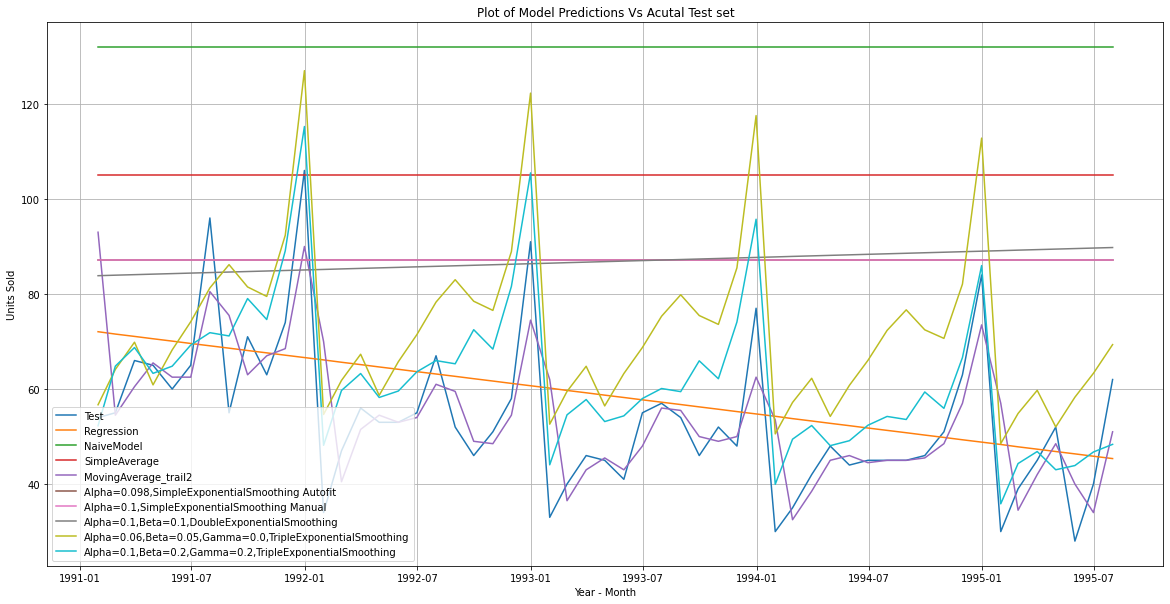

In [104]:
## Plotting of all models prediction values vs Test data

plt.figure(figsize=(20,10))
plt.plot(test['Rose'], label='Test')

plt.plot(lr_test['Regontime'], label='Regression')
plt.plot(NaiveModel_test['naive'], label='NaiveModel')
plt.plot(SimpleAverage_test['mean'], label='SimpleAverage')
plt.plot(MovingAverage_test['Trailing_2'], label='MovingAverage_trail2')

    
plt.plot(SES_test['predict'], label='Alpha=0.098,SimpleExponentialSmoothing Autofit')
plt.plot(SES_test['predict',0.1], label='Alpha=0.1,SimpleExponentialSmoothing Manual')

plt.plot(DES_test['predict', 0.1, 0.1], label='Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing')

plt.plot(TES_test['predict'], label='Alpha=0.06,Beta=0.05,Gamma=0.0,TripleExponentialSmoothing')
plt.plot(TES_test['predict', 0.1, 0.1, 0.2], label='Alpha=0.1,Beta=0.2,Gamma=0.2,TripleExponentialSmoothing')

plt.legend()
plt.grid();
plt.xlabel('Year - Month');
plt.ylabel('Units Sold');
plt.title('Plot of Model Predictions Vs Acutal Test set');

In [105]:
# Checking for stationarity of the whole data

In [106]:
dftest = adfuller(df,regression='ct')
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is' ,dftest[1])
print('Number of lags used' ,dftest[2])

DF test statistic is -2.241
DF test p-value is 0.46694206026101637
Number of lags used 13


In [107]:
dftest = adfuller(df.diff().dropna(),regression='ct')
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is' ,dftest[1])
print('Number of lags used' ,dftest[2])

DF test statistic is -8.161
DF test p-value is 3.028272263687806e-11
Number of lags used 12


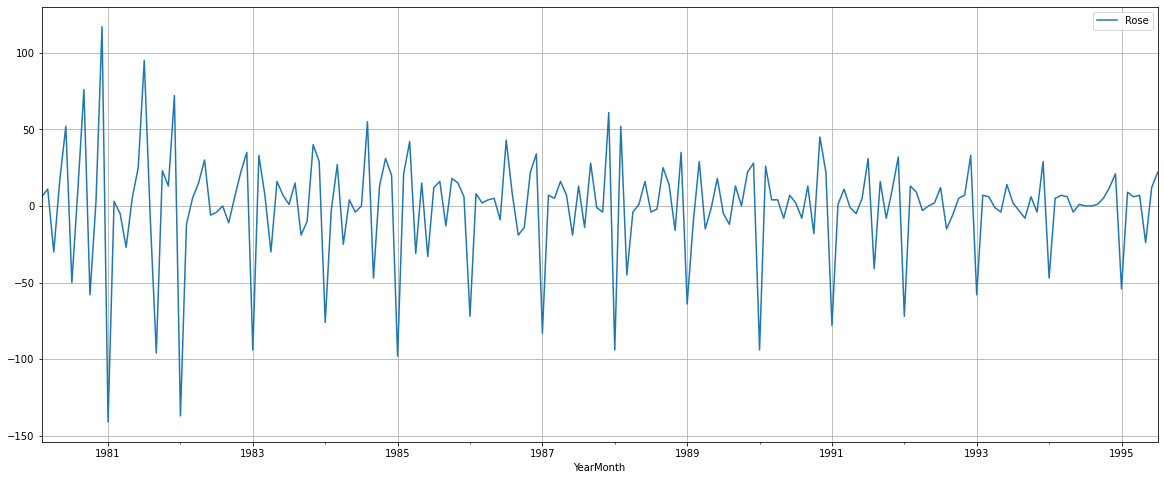

In [108]:
df.diff().dropna().plot(grid=True);

In [109]:
# Checking for stationarity of the train data

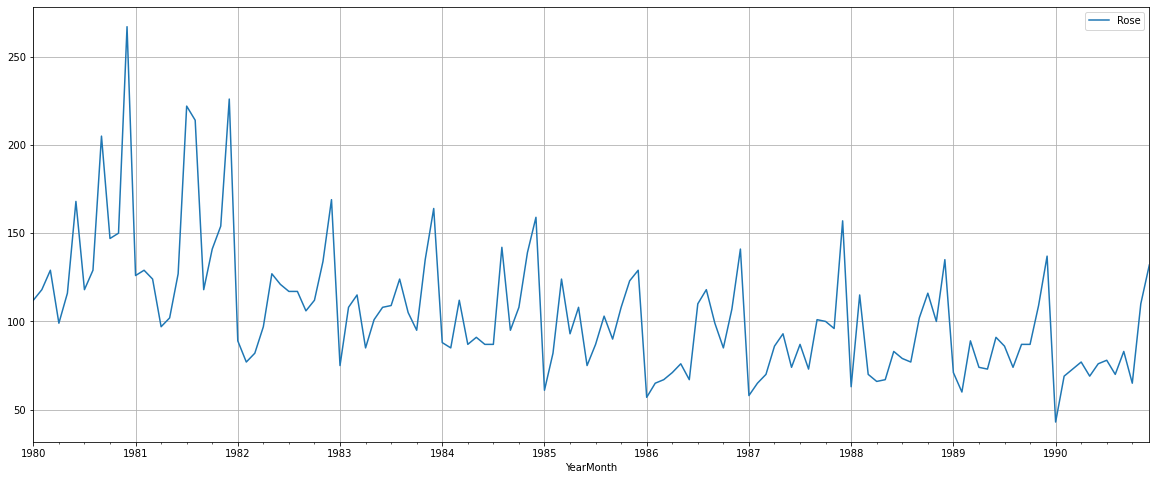

In [110]:
train.plot(grid=True);

In [111]:
dftest = adfuller(train,regression='ct')
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is' ,dftest[1])
print('Number of lags used' ,dftest[2])

DF test statistic is -1.686
DF test p-value is 0.7569093051047063
Number of lags used 13


In [112]:
dftest = adfuller(train.diff(1).dropna(),regression='ct')
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is' ,dftest[1])
print('Number of lags used' ,dftest[2])

DF test statistic is -6.804
DF test p-value is 3.8948313567816136e-08
Number of lags used 12


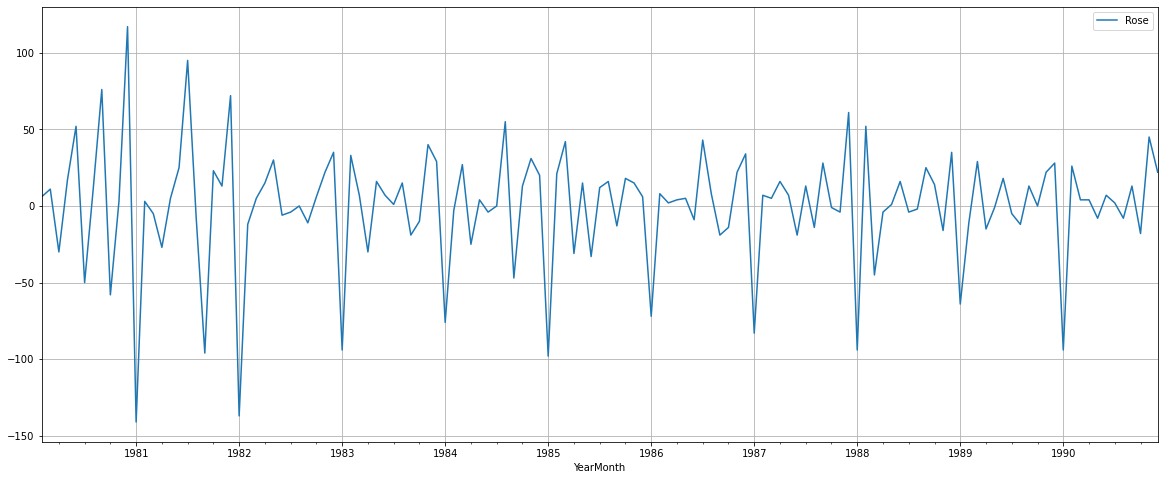

In [113]:
# Therfore value of d=1

train.diff().dropna().plot(grid=True);

In [114]:
# ARIMA model 

In [115]:
ARIMA_train = train.copy()
ARIMA_test = test.copy()

In [116]:
import itertools
p = q = range(0,4)
d= range(1,2)
pdq = list(itertools.product(p, d, q))
print('Examples of the parameter combinations for the Model')
for i in range(0,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Examples of the parameter combinations for the Model
Model: (0, 1, 0)
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 1, 3)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (1, 1, 3)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)
Model: (2, 1, 3)
Model: (3, 1, 0)
Model: (3, 1, 1)
Model: (3, 1, 2)
Model: (3, 1, 3)


In [117]:
# Creating an empty Dataframe with column names only
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

,param,AIC


In [118]:
for param in pdq:
    ARIMA_model = ARIMA(ARIMA_train['Rose'].values,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
    ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)

ARIMA(0, 1, 0) - AIC:1333.1546729124348
ARIMA(0, 1, 1) - AIC:1282.3098319748312
ARIMA(0, 1, 2) - AIC:1279.6715288535818
ARIMA(0, 1, 3) - AIC:1280.5453761734655
ARIMA(1, 1, 0) - AIC:1317.3503105381492
ARIMA(1, 1, 1) - AIC:1280.5742295380032
ARIMA(1, 1, 2) - AIC:1279.870723423191
ARIMA(1, 1, 3) - AIC:1281.8707223310003
ARIMA(2, 1, 0) - AIC:1298.6110341605004
ARIMA(2, 1, 1) - AIC:1281.5078621868474
ARIMA(2, 1, 2) - AIC:1281.8707222264284


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3) - AIC:1274.6949119626274
ARIMA(3, 1, 0) - AIC:1297.48109172717
ARIMA(3, 1, 1) - AIC:1282.4192776271977
ARIMA(3, 1, 2) - AIC:1283.720740597716
ARIMA(3, 1, 3) - AIC:1278.6588655941036


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [119]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

ARIMA_AIC.sort_values(by='AIC',ascending=True).head()

,param,AIC
11,"(2, 1, 3)",1274.694912
15,"(3, 1, 3)",1278.658866
2,"(0, 1, 2)",1279.671529
6,"(1, 1, 2)",1279.870723
3,"(0, 1, 3)",1280.545376


In [120]:
auto_ARIMA = ARIMA(ARIMA_train, order=(2,1,3))

results_auto_ARIMA = auto_ARIMA.fit()

print(results_auto_ARIMA.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  132
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -631.347
Date:                Sat, 15 Jan 2022   AIC                           1274.695
Time:                        20:05:29   BIC                           1291.946
Sample:                    01-31-1980   HQIC                          1281.705
                         - 12-31-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6781      0.084    -20.035      0.000      -1.842      -1.514
ar.L2         -0.7289      0.084     -8.703      0.000      -0.893      -0.565
ma.L1          1.0450      0.685      1.527      0.1

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


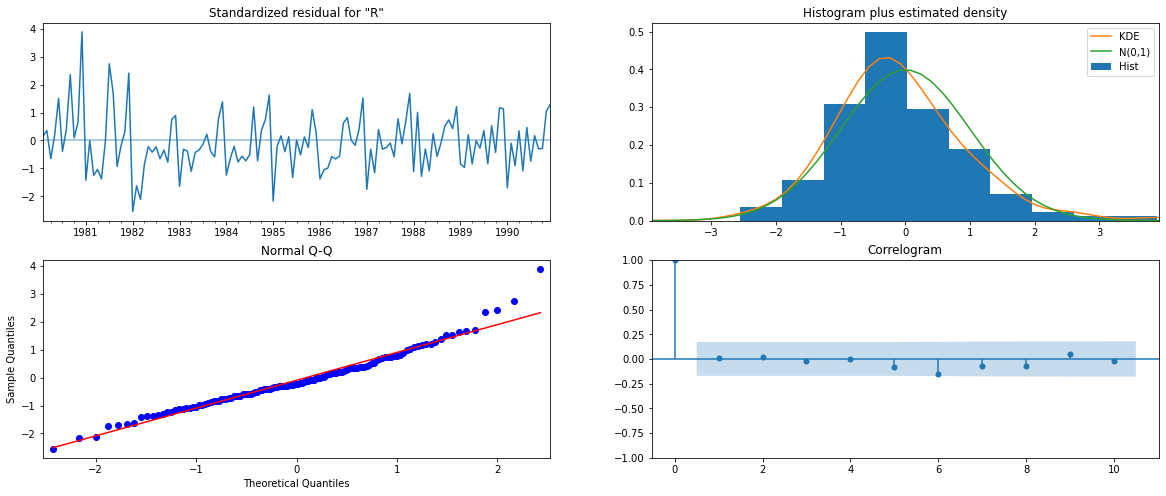

In [121]:
results_auto_ARIMA.plot_diagnostics();

In [122]:
# Predicting on the Test Set using this model and evaluate the model.

In [123]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(ARIMA_test))

In [124]:
rmse_arima = metrics.mean_squared_error(ARIMA_test['Rose'],predicted_auto_ARIMA,squared=False)
print('RMSE:',rmse_arima)

RMSE: 36.83800830441206


In [125]:
results_m8 = pd.DataFrame({'Test RMSE': [rmse_arima]},
                          index=['Alpha=2,Beta=1,Gamma=3,ARIMA Automated '])

results_m8 = pd.concat([results_m7_2,results_m8])
results_m8

,Test RMSE
RegressionOnTime,15.275732
Naive Model,79.738550
Simple Average,53.480857
2pointTrailingMovingAverage,11.529409
4pointTrailingMovingAverage,14.455221
6pointTrailingMovingAverage,14.572009
9pointTrailingMovingAverage,14.731209
"Alpha=0.098,SimpleExponentialSmoothing-Autofit",36.816889
"Alpha=0.1,SimpleExponentialSmoothing",36.848694
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",36.900871


In [126]:
# SARIMA model 

In [127]:
SARIMA_train = train.copy()
SARIMA_test = test.copy()

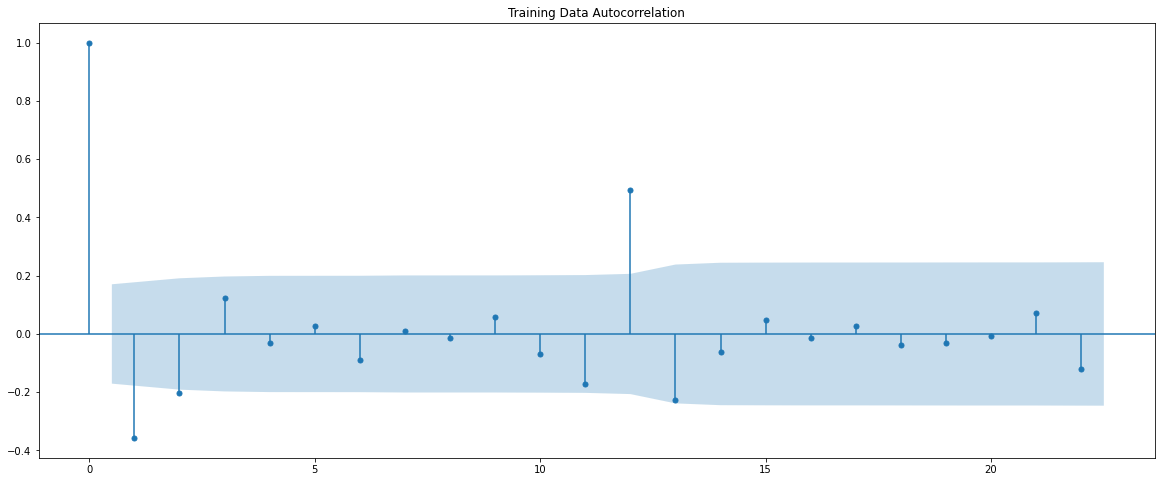

In [128]:
# We can see there is seasonality s = 12(taken as per multiple of 3)

plot_acf(SARIMA_train.diff(),title='Training Data Autocorrelation',missing='drop');

In [128]:
p = q = range(0,4)
d = range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
PDQ = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Examples of some parameter combinations for Model')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], PDQ[i]))

Examples of some parameter combinations for Model
Model: (0, 1, 1)(0, 0, 1, 12)
Model: (0, 1, 2)(0, 0, 2, 12)
Model: (0, 1, 3)(0, 0, 3, 12)
Model: (1, 1, 0)(1, 0, 0, 12)
Model: (1, 1, 1)(1, 0, 1, 12)
Model: (1, 1, 2)(1, 0, 2, 12)
Model: (1, 1, 3)(1, 0, 3, 12)
Model: (2, 1, 0)(2, 0, 0, 12)
Model: (2, 1, 1)(2, 0, 1, 12)
Model: (2, 1, 2)(2, 0, 2, 12)
Model: (2, 1, 3)(2, 0, 3, 12)
Model: (3, 1, 0)(3, 0, 0, 12)
Model: (3, 1, 1)(3, 0, 1, 12)
Model: (3, 1, 2)(3, 0, 2, 12)
Model: (3, 1, 3)(3, 0, 3, 12)


In [129]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

,param,seasonal,AIC


In [130]:
for param in pdq:
    for param_seasonal in PDQ:
        SARIMA_model = sm.tsa.statespace.SARIMAX(SARIMA_train['Rose'].values,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:1323.9657875279158
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1145.423082720733
SARIMA(0, 1, 0)x(0, 0, 2, 12) - AIC:976.4375296380911


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 0)x(0, 0, 3, 12) - AIC:4620.270461546251
SARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:1139.921738995602
SARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1116.0207869386036
SARIMA(0, 1, 0)x(1, 0, 2, 12) - AIC:969.6913635753504
SARIMA(0, 1, 0)x(1, 0, 3, 12) - AIC:3001.451859547566
SARIMA(0, 1, 0)x(2, 0, 0, 12) - AIC:960.8812220353041
SARIMA(0, 1, 0)x(2, 0, 1, 12) - AIC:962.8794540697521

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMA(0, 1, 0)x(2, 0, 2, 12) - AIC:955.573540894562


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 0)x(2, 0, 3, 12) - AIC:3825.0727815583987
SARIMA(0, 1, 0)x(3, 0, 0, 12) - AIC:850.7535403931095
SARIMA(0, 1, 0)x(3, 0, 1, 12) - AIC:851.7482702637687
SARIMA(0, 1, 0)x(3, 0, 2, 12) - AIC:850.5304136128542


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 0)x(3, 0, 3, 12) - AIC:3506.213452181075
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:1263.5369097383964
SARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:1098.5554825918337
SARIMA(0, 1, 1)x(0, 0, 2, 12) - AIC:923.6314049383859


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 1)x(0, 0, 3, 12) - AIC:4062.432568320479
SARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:1095.793632491795
SARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:1054.743433094527
SARIMA(0, 1, 1)x(1, 0, 2, 12) - AIC:918.8573483302789


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 1)x(1, 0, 3, 12) - AIC:3718.620916180553
SARIMA(0, 1, 1)x(2, 0, 0, 12) - AIC:914.5982866536075
SARIMA(0, 1, 1)x(2, 0, 1, 12) - AIC:915.3332430461672
SARIMA(0, 1, 1)x(2, 0, 2, 12) - AIC:901.1988271349375


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 1)x(2, 0, 3, 12) - AIC:3475.197712959759
SARIMA(0, 1, 1)x(3, 0, 0, 12) - AIC:798.5889764801797
SARIMA(0, 1, 1)x(3, 0, 1, 12) - AIC:800.4844936083293
SARIMA(0, 1, 1)x(3, 0, 2, 12) - AIC:801.0595269404402


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 1)x(3, 0, 3, 12) - AIC:3508.2439683333064
SARIMA(0, 1, 2)x(0, 0, 0, 12) - AIC:1251.6675430541054
SARIMA(0, 1, 2)x(0, 0, 1, 12) - AIC:1083.486697526487
SARIMA(0, 1, 2)x(0, 0, 2, 12) - AIC:913.4938486617702


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 2)x(0, 0, 3, 12) - AIC:2995.603286311332
SARIMA(0, 1, 2)x(1, 0, 0, 12) - AIC:1088.8332843413825
SARIMA(0, 1, 2)x(1, 0, 1, 12) - AIC:1045.5400933538035
SARIMA(0, 1, 2)x(1, 0, 2, 12) - AIC:904.8310913587571
SARIMA(0, 1, 2)x(1, 0, 3, 12) - AIC:3717.7114967843636
SARIMA(0, 1, 2)x(2, 0, 0, 12) - AIC:913.0105912257991
SARIMA(0, 1, 2)x(2, 0, 1, 12) - AIC:914.1707545034917
SARIMA(0, 1, 2)x(2, 0, 2, 12) - AIC:887.9375085680747


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 2)x(2, 0, 3, 12) - AIC:3721.736733448757
SARIMA(0, 1, 2)x(3, 0, 0, 12) - AIC:800.102018937503
SARIMA(0, 1, 2)x(3, 0, 1, 12) - AIC:801.9941080529609
SARIMA(0, 1, 2)x(3, 0, 2, 12) - AIC:802.5206528369222


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 2)x(3, 0, 3, 12) - AIC:3022.507177404176
SARIMA(0, 1, 3)x(0, 0, 0, 12) - AIC:1243.950121673916
SARIMA(0, 1, 3)x(0, 0, 1, 12) - AIC:1076.7632646075988
SARIMA(0, 1, 3)x(0, 0, 2, 12) - AIC:905.692653338052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 3)x(0, 0, 3, 12) - AIC:3964.111036852745
SARIMA(0, 1, 3)x(1, 0, 0, 12) - AIC:1089.2051361212216
SARIMA(0, 1, 3)x(1, 0, 1, 12) - AIC:1034.8411212935393
SARIMA(0, 1, 3)x(1, 0, 2, 12) - AIC:896.8362523340518
SARIMA(0, 1, 3)x(1, 0, 3, 12) - AIC:3691.6056447848573
SARIMA(0, 1, 3)x(2, 0, 0, 12) - AIC:914.9477108987116
SARIMA(0, 1, 3)x(2, 0, 1, 12) - AIC:916.0630996882174
SARIMA(0, 1, 3)x(2, 0, 2, 12) - AIC:880.5509788252531


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 3)x(2, 0, 3, 12) - AIC:3569.415018113366
SARIMA(0, 1, 3)x(3, 0, 0, 12) - AIC:802.0987124792142
SARIMA(0, 1, 3)x(3, 0, 1, 12) - AIC:803.9928772360103
SARIMA(0, 1, 3)x(3, 0, 2, 12) - AIC:804.5150722271089
SARIMA(0, 1, 3)x(3, 0, 3, 12) - AIC:3537.6571790084263
SARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:1308.161871082466
SARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:1135.2955447585707
SARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC:963.9405391257685


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 0)x(0, 0, 3, 12) - AIC:3897.039485633808
SARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:1124.886078680458
SARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:1105.408005502361
SARIMA(1, 1, 0)x(1, 0, 2, 12) - AIC:958.5001972947882


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 0)x(1, 0, 3, 12) - AIC:3262.9364483444133
SARIMA(1, 1, 0)x(2, 0, 0, 12) - AIC:939.0984778664119
SARIMA(1, 1, 0)x(2, 0, 1, 12) - AIC:940.9087133661069
SARIMA(1, 1, 0)x(2, 0, 2, 12) - AIC:942.2973103071218


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 0)x(2, 0, 3, 12) - AIC:3111.9838445149994
SARIMA(1, 1, 0)x(3, 0, 0, 12) - AIC:819.3931032272566
SARIMA(1, 1, 0)x(3, 0, 1, 12) - AIC:821.1501371573531
SARIMA(1, 1, 0)x(3, 0, 2, 12) - AIC:819.1305086853467


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 0)x(3, 0, 3, 12) - AIC:3342.302711347493
SARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:1262.1840064255505
SARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:1094.3172708640957
SARIMA(1, 1, 1)x(0, 0, 2, 12) - AIC:923.0862224063864
SARIMA(1, 1, 1)x(0, 0, 3, 12) - AIC:4168.023459327619
SARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:1083.3937965031257
SARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:1054.7180547135954
SARIMA(1, 1, 1)x(1, 0, 2, 12) - AIC:916.3549428508104


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 1)x(1, 0, 3, 12) - AIC:3732.743010890288
SARIMA(1, 1, 1)x(2, 0, 0, 12) - AIC:905.9249060841146
SARIMA(1, 1, 1)x(2, 0, 1, 12) - AIC:907.2972867470805
SARIMA(1, 1, 1)x(2, 0, 2, 12) - AIC:900.6725795936803


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 1)x(2, 0, 3, 12) - AIC:3557.917787006939
SARIMA(1, 1, 1)x(3, 0, 0, 12) - AIC:789.2360439389992
SARIMA(1, 1, 1)x(3, 0, 1, 12) - AIC:790.9603447834212
SARIMA(1, 1, 1)x(3, 0, 2, 12) - AIC:790.8113850291048
SARIMA(1, 1, 1)x(3, 0, 3, 12) - AIC:3563.2199465467197
SARIMA(1, 1, 2)x(0, 0, 0, 12) - AIC:1251.9495040706292
SARIMA(1, 1, 2)x(0, 0, 1, 12) - AIC:1085.4861928101045
SARIMA(1, 1, 2)x(0, 0, 2, 12) - AIC:915.493840263531


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 2)x(0, 0, 3, 12) - AIC:4051.714817114274
SARIMA(1, 1, 2)x(1, 0, 0, 12) - AIC:1090.776092785662
SARIMA(1, 1, 2)x(1, 0, 1, 12) - AIC:1042.6183211407576
SARIMA(1, 1, 2)x(1, 0, 2, 12) - AIC:906.7318500516412
SARIMA(1, 1, 2)x(1, 0, 3, 12) - AIC:3755.4221674978044
SARIMA(1, 1, 2)x(2, 0, 0, 12) - AIC:906.1690196723837
SARIMA(1, 1, 2)x(2, 0, 1, 12) - AIC:907.4597827897728
SARIMA(1, 1, 2)x(2, 0, 2, 12) - AIC:889.9030478809166


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 2)x(2, 0, 3, 12) - AIC:3423.8013701947248
SARIMA(1, 1, 2)x(3, 0, 0, 12) - AIC:791.007380145697
SARIMA(1, 1, 2)x(3, 0, 1, 12) - AIC:792.6312809940029
SARIMA(1, 1, 2)x(3, 0, 2, 12) - AIC:792.1390257573922


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 2)x(3, 0, 3, 12) - AIC:3494.1268982494853
SARIMA(1, 1, 3)x(0, 0, 0, 12) - AIC:1245.5463125316173
SARIMA(1, 1, 3)x(0, 0, 1, 12) - AIC:1072.9849739845033
SARIMA(1, 1, 3)x(0, 0, 2, 12) - AIC:907.4130105110019


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 3)x(0, 0, 3, 12) - AIC:2824.860505872683
SARIMA(1, 1, 3)x(1, 0, 0, 12) - AIC:1082.3281487676015
SARIMA(1, 1, 3)x(1, 0, 1, 12) - AIC:1036.1950928744955
SARIMA(1, 1, 3)x(1, 0, 2, 12) - AIC:897.5232291617485
SARIMA(1, 1, 3)x(1, 0, 3, 12) - AIC:3716.7762765995117
SARIMA(1, 1, 3)x(2, 0, 0, 12) - AIC:908.2687610975237
SARIMA(1, 1, 3)x(2, 0, 1, 12) - AIC:909.7955660054643
SARIMA(1, 1, 3)x(2, 0, 2, 12) - AIC:880.2886589266546
SARIMA(1, 1, 3)x(2, 0, 3, 12) - AIC:3417.303909153494
SARIMA(1, 1, 3)x(3, 0, 0, 12) - AIC:792.990313358708
SARIMA(1, 1, 3)x(3, 0, 1, 12) - AIC:794.6310140547828
SARIMA(1, 1, 3)x(3, 0, 2, 12) - AIC:794.0467927115388


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 3)x(3, 0, 3, 12) - AIC:2947.8869996827502
SARIMA(2, 1, 0)x(0, 0, 0, 12) - AIC:1280.253756153577
SARIMA(2, 1, 0)x(0, 0, 1, 12) - AIC:1128.777370471132
SARIMA(2, 1, 0)x(0, 0, 2, 12) - AIC:958.0793208829961


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 0)x(0, 0, 3, 12) - AIC:4209.772770019851
SARIMA(2, 1, 0)x(1, 0, 0, 12) - AIC:1099.5086021575974
SARIMA(2, 1, 0)x(1, 0, 1, 12) - AIC:1076.786319864116
SARIMA(2, 1, 0)x(1, 0, 2, 12) - AIC:951.1988165558708


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 0)x(1, 0, 3, 12) - AIC:3576.9669900775016
SARIMA(2, 1, 0)x(2, 0, 0, 12) - AIC:924.6004792645396
SARIMA(2, 1, 0)x(2, 0, 1, 12) - AIC:925.9757801384483
SARIMA(2, 1, 0)x(2, 0, 2, 12) - AIC:927.8380693280824
SARIMA(2, 1, 0)x(2, 0, 3, 12) - AIC:3461.6314416352716
SARIMA(2, 1, 0)x(3, 0, 0, 12) - AIC:806.0536407408968
SARIMA(2, 1, 0)x(3, 0, 1, 12) - AIC:808.0472637902985
SARIMA(2, 1, 0)x(3, 0, 2, 12) - AIC:806.4988191372563


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 0)x(3, 0, 3, 12) - AIC:3860.4861491612473
SARIMA(2, 1, 1)x(0, 0, 0, 12) - AIC:1263.2315231800053
SARIMA(2, 1, 1)x(0, 0, 1, 12) - AIC:1094.2093491949408
SARIMA(2, 1, 1)x(0, 0, 2, 12) - AIC:922.9408472075866
SARIMA(2, 1, 1)x(0, 0, 3, 12) - AIC:4170.023459327611
SARIMA(2, 1, 1)x(1, 0, 0, 12) - AIC:1071.4249601101312
SARIMA(2, 1, 1)x(1, 0, 1, 12) - AIC:1052.9244471204865
SARIMA(2, 1, 1)x(1, 0, 2, 12) - AIC:916.2424912822669


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1)x(1, 0, 3, 12) - AIC:3093.4774607500367
SARIMA(2, 1, 1)x(2, 0, 0, 12) - AIC:896.5181608195448
SARIMA(2, 1, 1)x(2, 0, 1, 12) - AIC:897.6399565369483
SARIMA(2, 1, 1)x(2, 0, 2, 12) - AIC:899.4835866279672
SARIMA(2, 1, 1)x(2, 0, 3, 12) - AIC:3487.871349162793
SARIMA(2, 1, 1)x(3, 0, 0, 12) - AIC:785.3932600274738
SARIMA(2, 1, 1)x(3, 0, 1, 12) - AIC:787.3639258898208
SARIMA(2, 1, 1)x(3, 0, 2, 12) - AIC:787.0598888684405


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1)x(3, 0, 3, 12) - AIC:3605.500079107335
SARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC:1253.91021161467
SARIMA(2, 1, 2)x(0, 0, 1, 12) - AIC:1085.9643552598225
SARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:916.3258311098716


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(0, 0, 3, 12) - AIC:3823.694830478731
SARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:1073.2912713669489
SARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:1044.190935440186
SARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:907.6661488807475
SARIMA(2, 1, 2)x(1, 0, 3, 12) - AIC:3625.6087705733435
SARIMA(2, 1, 2)x(2, 0, 0, 12) - AIC:897.3464442046732
SARIMA(2, 1, 2)x(2, 0, 1, 12) - AIC:898.3781889026694
SARIMA(2, 1, 2)x(2, 0, 2, 12) - AIC:890.6687981146545


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(2, 0, 3, 12) - AIC:3712.8594043560197
SARIMA(2, 1, 2)x(3, 0, 0, 12) - AIC:785.1199712642695
SARIMA(2, 1, 2)x(3, 0, 1, 12) - AIC:786.9410035569343
SARIMA(2, 1, 2)x(3, 0, 2, 12) - AIC:786.9640489468518


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(3, 0, 3, 12) - AIC:3440.671558425702
SARIMA(2, 1, 3)x(0, 0, 0, 12) - AIC:1237.8702126608182
SARIMA(2, 1, 3)x(0, 0, 1, 12) - AIC:1067.8073334028375
SARIMA(2, 1, 3)x(0, 0, 2, 12) - AIC:908.3349289476025


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 3)x(0, 0, 3, 12) - AIC:4062.481905973044
SARIMA(2, 1, 3)x(1, 0, 0, 12) - AIC:1073.256323495537
SARIMA(2, 1, 3)x(1, 0, 1, 12) - AIC:1024.0462094898394
SARIMA(2, 1, 3)x(1, 0, 2, 12) - AIC:890.9483348392333


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 3)x(1, 0, 3, 12) - AIC:3696.541895887875
SARIMA(2, 1, 3)x(2, 0, 0, 12) - AIC:893.3579301935372
SARIMA(2, 1, 3)x(2, 0, 1, 12) - AIC:903.232809308032
SARIMA(2, 1, 3)x(2, 0, 2, 12) - AIC:879.2191807601847


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 3)x(2, 0, 3, 12) - AIC:3591.9058283974564
SARIMA(2, 1, 3)x(3, 0, 0, 12) - AIC:782.407420793161
SARIMA(2, 1, 3)x(3, 0, 1, 12) - AIC:783.4101469602371
SARIMA(2, 1, 3)x(3, 0, 2, 12) - AIC:781.0452491035072


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 3)x(3, 0, 3, 12) - AIC:3449.7421230120494
SARIMA(3, 1, 0)x(0, 0, 0, 12) - AIC:1269.8130062641503
SARIMA(3, 1, 0)x(0, 0, 1, 12) - AIC:1119.1703158042226
SARIMA(3, 1, 0)x(0, 0, 2, 12) - AIC:953.344058911804
SARIMA(3, 1, 0)x(0, 0, 3, 12) - AIC:4214.711883621455
SARIMA(3, 1, 0)x(1, 0, 0, 12) - AIC:1080.546845672644
SARIMA(3, 1, 0)x(1, 0, 1, 12) - AIC:1065.5569726784483
SARIMA(3, 1, 0)x(1, 0, 2, 12) - AIC:943.6865996304899


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 0)x(1, 0, 3, 12) - AIC:3813.3775274479117
SARIMA(3, 1, 0)x(2, 0, 0, 12) - AIC:909.72031978875
SARIMA(3, 1, 0)x(2, 0, 1, 12) - AIC:911.0620713976489
SARIMA(3, 1, 0)x(2, 0, 2, 12) - AIC:913.0438816472868
SARIMA(3, 1, 0)x(2, 0, 3, 12) - AIC:3537.047983050635
SARIMA(3, 1, 0)x(3, 0, 0, 12) - AIC:796.0564701527572
SARIMA(3, 1, 0)x(3, 0, 1, 12) - AIC:795.5410167661679
SARIMA(3, 1, 0)x(3, 0, 2, 12) - AIC:794.6677017201754


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 0)x(3, 0, 3, 12) - AIC:3481.9774975511327
SARIMA(3, 1, 1)x(0, 0, 0, 12) - AIC:1255.065818070936
SARIMA(3, 1, 1)x(0, 0, 1, 12) - AIC:1095.6894641197794
SARIMA(3, 1, 1)x(0, 0, 2, 12) - AIC:923.8872427547217
SARIMA(3, 1, 1)x(0, 0, 3, 12) - AIC:4172.023459327611
SARIMA(3, 1, 1)x(1, 0, 0, 12) - AIC:1064.6149136511087
SARIMA(3, 1, 1)x(1, 0, 1, 12) - AIC:1046.0837554147536
SARIMA(3, 1, 1)x(1, 0, 2, 12) - AIC:917.0308009384327
SARIMA(3, 1, 1)x(1, 0, 3, 12) - AIC:3540.446319723089
SARIMA(3, 1, 1)x(2, 0, 0, 12) - AIC:887.3204459899297
SARIMA(3, 1, 1)x(2, 0, 1, 12) - AIC:888.327920853788
SARIMA(3, 1, 1)x(2, 0, 2, 12) - AIC:890.1571523254606


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(2, 0, 3, 12) - AIC:3342.6350965983884
SARIMA(3, 1, 1)x(3, 0, 0, 12) - AIC:775.4266990321439
SARIMA(3, 1, 1)x(3, 0, 1, 12) - AIC:775.495330077771
SARIMA(3, 1, 1)x(3, 0, 2, 12) - AIC:774.4002851035427


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(3, 0, 3, 12) - AIC:3730.687553115494
SARIMA(3, 1, 2)x(0, 0, 0, 12) - AIC:1255.9835656475343
SARIMA(3, 1, 2)x(0, 0, 1, 12) - AIC:1086.7092401101968
SARIMA(3, 1, 2)x(0, 0, 2, 12) - AIC:917.7980110893807
SARIMA(3, 1, 2)x(0, 0, 3, 12) - AIC:3971.0855532681926
SARIMA(3, 1, 2)x(1, 0, 0, 12) - AIC:1066.277621132881
SARIMA(3, 1, 2)x(1, 0, 1, 12) - AIC:1046.1260517049286
SARIMA(3, 1, 2)x(1, 0, 2, 12) - AIC:909.2875120094859


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 2)x(1, 0, 3, 12) - AIC:3834.195129926922
SARIMA(3, 1, 2)x(2, 0, 0, 12) - AIC:889.3181034638479
SARIMA(3, 1, 2)x(2, 0, 1, 12) - AIC:890.327744122761
SARIMA(3, 1, 2)x(2, 0, 2, 12) - AIC:896.1435524976398


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 2)x(2, 0, 3, 12) - AIC:3833.258043595455
SARIMA(3, 1, 2)x(3, 0, 0, 12) - AIC:777.2505640347919
SARIMA(3, 1, 2)x(3, 0, 1, 12) - AIC:776.3462133374693
SARIMA(3, 1, 2)x(3, 0, 2, 12) - AIC:774.8809352377456


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 2)x(3, 0, 3, 12) - AIC:3801.4989898897093
SARIMA(3, 1, 3)x(0, 0, 0, 12) - AIC:1243.7385948310948
SARIMA(3, 1, 3)x(0, 0, 1, 12) - AIC:1060.5397666855608
SARIMA(3, 1, 3)x(0, 0, 2, 12) - AIC:910.3340185886154


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 3)x(0, 0, 3, 12) - AIC:3824.8706629855174
SARIMA(3, 1, 3)x(1, 0, 0, 12) - AIC:1066.9413369514314
SARIMA(3, 1, 3)x(1, 0, 1, 12) - AIC:1039.766238012301
SARIMA(3, 1, 3)x(1, 0, 2, 12) - AIC:900.048366040204


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 3)x(1, 0, 3, 12) - AIC:3889.840372989331
SARIMA(3, 1, 3)x(2, 0, 0, 12) - AIC:884.0463711769332
SARIMA(3, 1, 3)x(2, 0, 1, 12) - AIC:885.9217103128233
SARIMA(3, 1, 3)x(2, 0, 2, 12) - AIC:880.5595715165068


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 3)x(2, 0, 3, 12) - AIC:3595.4086305900537
SARIMA(3, 1, 3)x(3, 0, 0, 12) - AIC:775.5610184890733
SARIMA(3, 1, 3)x(3, 0, 1, 12) - AIC:776.3690402698232
SARIMA(3, 1, 3)x(3, 0, 2, 12) - AIC:778.2316176299639
SARIMA(3, 1, 3)x(3, 0, 3, 12) - AIC:2787.0991450218853


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [131]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

SARIMA_AIC.sort_values(by=['AIC']).head()

,param,seasonal,AIC
222,"(3, 1, 1)","(3, 0, 2, 12)",774.400285
238,"(3, 1, 2)","(3, 0, 2, 12)",774.880935
220,"(3, 1, 1)","(3, 0, 0, 12)",775.426699
221,"(3, 1, 1)","(3, 0, 1, 12)",775.495330
252,"(3, 1, 3)","(3, 0, 0, 12)",775.561018


In [132]:
auto_SARIMA = sm.tsa.statespace.SARIMAX(SARIMA_train['Rose'].values,
                                order=(3, 1, 1),
                                seasonal_order=(3, 0, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_auto_SARIMA = auto_SARIMA.fit(maxiter=1000)
print(results_auto_SARIMA.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  132
Model:             SARIMAX(3, 1, 1)x(3, 0, [1, 2], 12)   Log Likelihood                -377.200
Date:                                 Sat, 15 Jan 2022   AIC                            774.400
Time:                                         20:11:42   BIC                            799.618
Sample:                                              0   HQIC                           784.578
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0464      0.126      0.367      0.714      -0.202       0

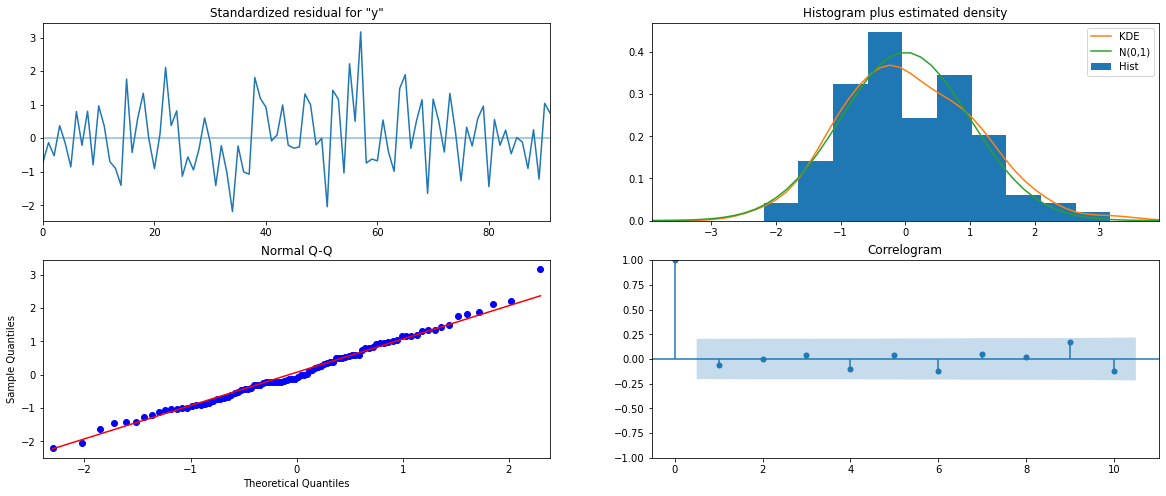

In [133]:
results_auto_SARIMA.plot_diagnostics();

In [134]:
# Predicting on the Test Set using this model and evaluate the model.

In [135]:
predicted_auto_SARIMA = results_auto_SARIMA.get_forecast(steps=len(SARIMA_test))

In [136]:
predicted_auto_SARIMA.summary_frame(alpha=0.05).head()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,55.235177,13.907798,27.976394,82.493961
1,68.123048,13.991243,40.700716,95.545380
2,67.908690,14.012295,40.445097,95.372283
3,66.786179,14.099601,39.151469,94.420890
4,69.760071,14.108960,42.107017,97.413125


In [137]:
rmse_sarima = metrics.mean_squared_error(SARIMA_test['Rose'],predicted_auto_SARIMA.predicted_mean,squared=False)
print('RMSE:',rmse_sarima)

RMSE: 18.903314735969182


In [138]:
results_m9 = pd.DataFrame({'Test RMSE': [rmse_sarima]},
                          index=['pdq=(3,1,1),PDQS=(3,1,1,12),SARIMA Automated'])

results_m9 = pd.concat([results_m8,results_m9])
results_m9

,Test RMSE
RegressionOnTime,15.275732
Naive Model,79.738550
Simple Average,53.480857
2pointTrailingMovingAverage,11.529409
4pointTrailingMovingAverage,14.455221
6pointTrailingMovingAverage,14.572009
9pointTrailingMovingAverage,14.731209
"Alpha=0.098,SimpleExponentialSmoothing-Autofit",36.816889
"Alpha=0.1,SimpleExponentialSmoothing",36.848694
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",36.900871


In [211]:
# ARIMA Model using ACF and PACF plots

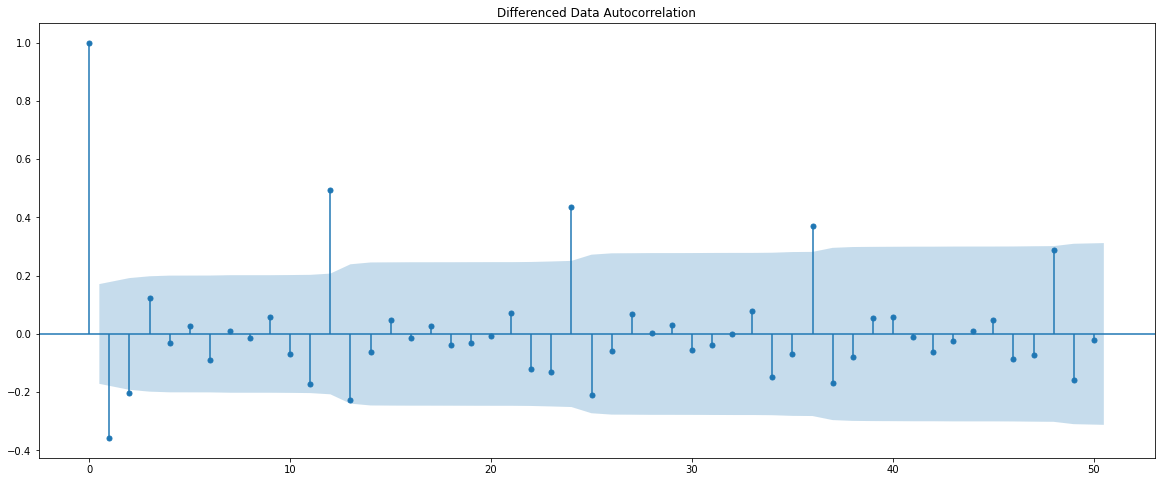

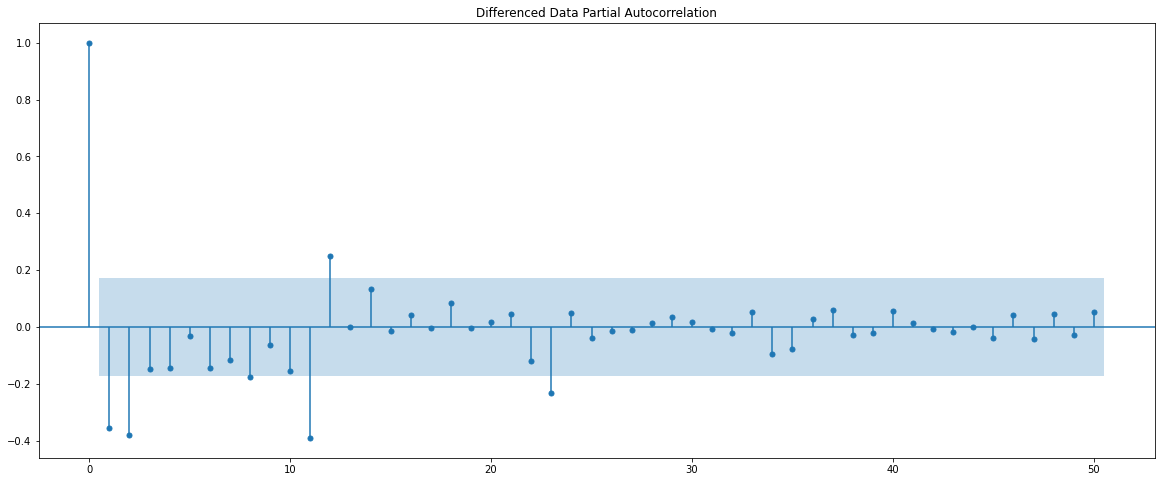

In [51]:
# Best parameters are selected by looking at the ACF and the PACF plot

plot_acf(train.diff().dropna(), lags=50, title='Differenced Data Autocorrelation',missing='drop')
plot_pacf(train.diff().dropna(), lags=50, title='Differenced Data Partial Autocorrelation',method='ywmle')
plt.show()

In [140]:
'''Here, we have taken alpha=0.05.

The Auto-Regressive parameter in an ARIMA model is 'p' which comes from the significant lag before which the PACF plot cuts-off to 0.
The Moving-Average parameter in an ARIMA model is 'q' which comes from the significant lag before the ACF plot cuts-off to 0.
'''

"Here, we have taken alpha=0.05.\n\nThe Auto-Regressive parameter in an ARIMA model is 'p' which comes from the significant lag before which the PACF plot cuts-off to 0.\nThe Moving-Average parameter in an ARIMA model is 'q' which comes from the significant lag before the ACF plot cuts-off to 0.\n"

In [141]:
manual_ARIMA = ARIMA(train['Rose'], order=(0,1,0))

results_manual_ARIMA = manual_ARIMA.fit()

print(results_manual_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  132
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -665.577
Date:                Sat, 15 Jan 2022   AIC                           1333.155
Time:                        20:12:11   BIC                           1336.030
Sample:                    01-31-1980   HQIC                          1334.323
                         - 12-31-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1515.6738    122.418     12.381      0.000    1275.740    1755.608
Ljung-Box (L1) (Q):                  17.11   Jarque-Bera (JB):                59.55
Prob(Q):                              0.00   Pr

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


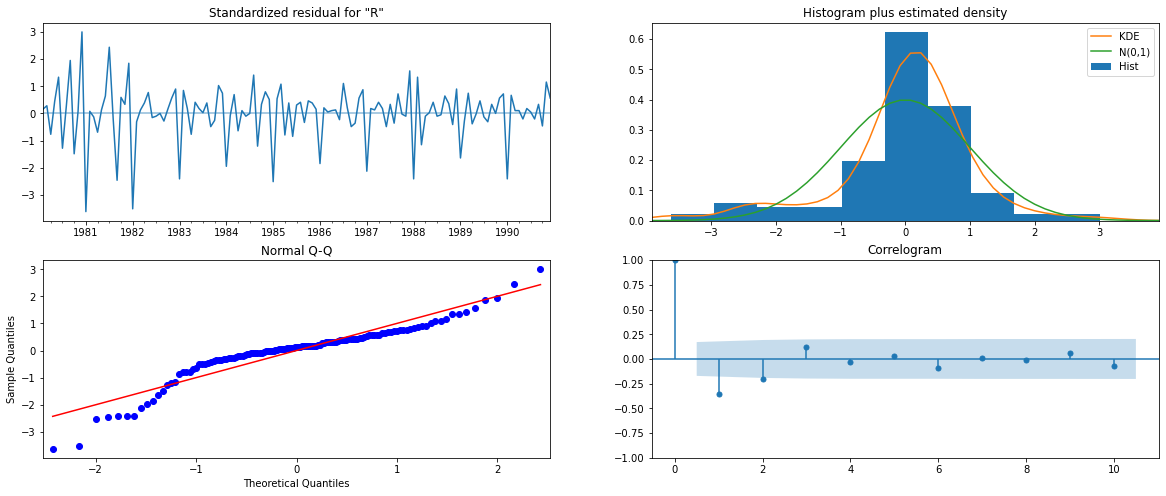

In [142]:
results_manual_ARIMA.plot_diagnostics();

In [143]:
# Predicting on the Test Set using this model and evaluate the model.

In [144]:
predicted_manual_ARIMA = results_manual_ARIMA.forecast(steps=len(test))

In [145]:
rmse_manual_arima = metrics.mean_squared_error(test['Rose'],predicted_manual_ARIMA,squared=False)
print(rmse_manual_arima)

79.73855004724103


In [158]:
results_m10 = pd.DataFrame({'Test RMSE': [rmse_manual_arima]},
                          index=['Alpha=0,Beta=1,Gamma=0,ARIMA Manual'])

results_m10 = pd.concat([results_m9,results_m10])
results_m10

,Test RMSE
RegressionOnTime,15.275732
Naive Model,79.738550
Simple Average,53.480857
2pointTrailingMovingAverage,11.529409
4pointTrailingMovingAverage,14.455221
6pointTrailingMovingAverage,14.572009
9pointTrailingMovingAverage,14.731209
"Alpha=0.098,SimpleExponentialSmoothing-Autofit",36.816889
"Alpha=0.1,SimpleExponentialSmoothing",36.848694
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",36.900871


In [159]:
# SARIMA Model using ACF and PACF plots

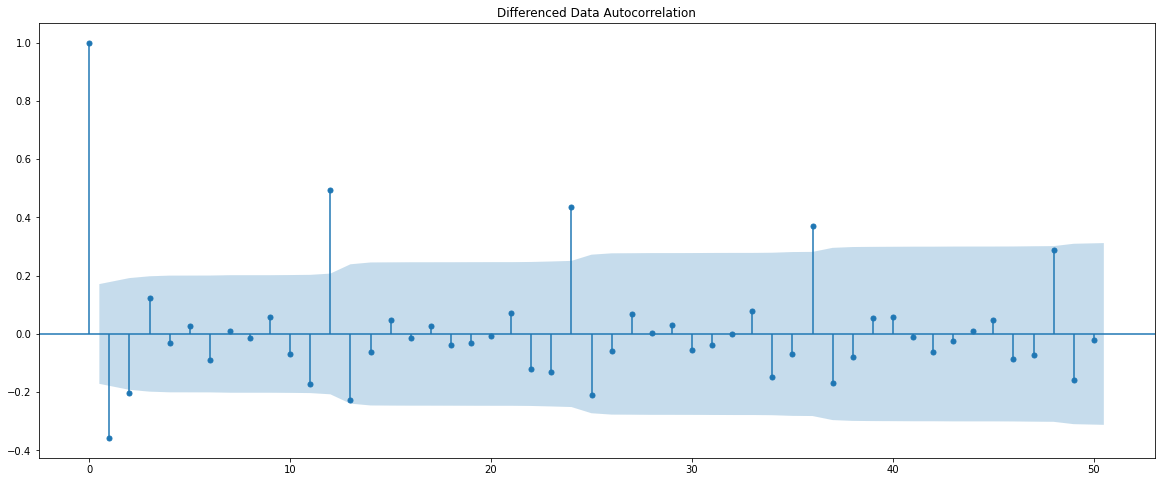

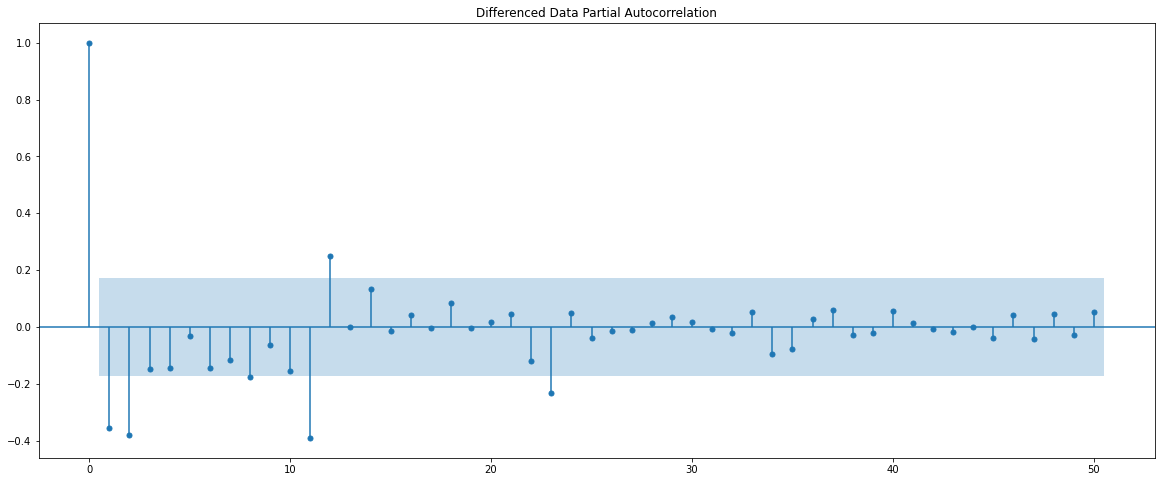

In [52]:
# Best parameters are selected by looking at the ACF and the PACF plot

plot_acf(train.diff().dropna(), lags=50, title='Differenced Data Autocorrelation',missing='drop')
plot_pacf(train.diff().dropna(), lags=50, title='Differenced Data Partial Autocorrelation',method='ywmle')
plt.show()

In [161]:
'''Here, we have taken alpha=0.05.

We are going to take the seasonal period as 12. We will keep the p = 0 and q = 0 parameters same as the ARIMA model.

The Auto-Regressive parameter in an SARIMA model is 'P' which comes from the significant lag after which the PACF plot cuts-off to 0.
The Moving-Average parameter in an SARIMA model is 'Q' which comes from the significant lag after which the ACF plot cuts-off to 0. 
We have checked the ACF and the PACF plots only at multiples of 12 (since 12 is the seasonal period).'''

"Here, we have taken alpha=0.05.\n\nWe are going to take the seasonal period as 12. We will keep the p = 0 and q = 0 parameters same as the ARIMA model.\n\nThe Auto-Regressive parameter in an SARIMA model is 'P' which comes from the significant lag after which the PACF plot cuts-off to 0.\nThe Moving-Average parameter in an SARIMA model is 'Q' which comes from the significant lag after which the ACF plot cuts-off to 0. \nWe have checked the ACF and the PACF plots only at multiples of 12 (since 12 is the seasonal period)."

In [162]:
manual_SARIMA = sm.tsa.statespace.SARIMAX(train['Rose'].values,
                                order=(0, 1, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_manual_SARIMA = manual_SARIMA.fit(maxiter=1000)
print(results_manual_SARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -660.983
Date:                Sat, 15 Jan 2022   AIC                           1323.966
Time:                        20:15:08   BIC                           1326.833
Sample:                             0   HQIC                          1325.131
                                - 132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1527.0558    124.361     12.279      0.000    1283.314    1770.798
Ljung-Box (L1) (Q):                  17.02   Jarque-Bera (JB):                57.49
Prob(Q):                              0.00   Pr

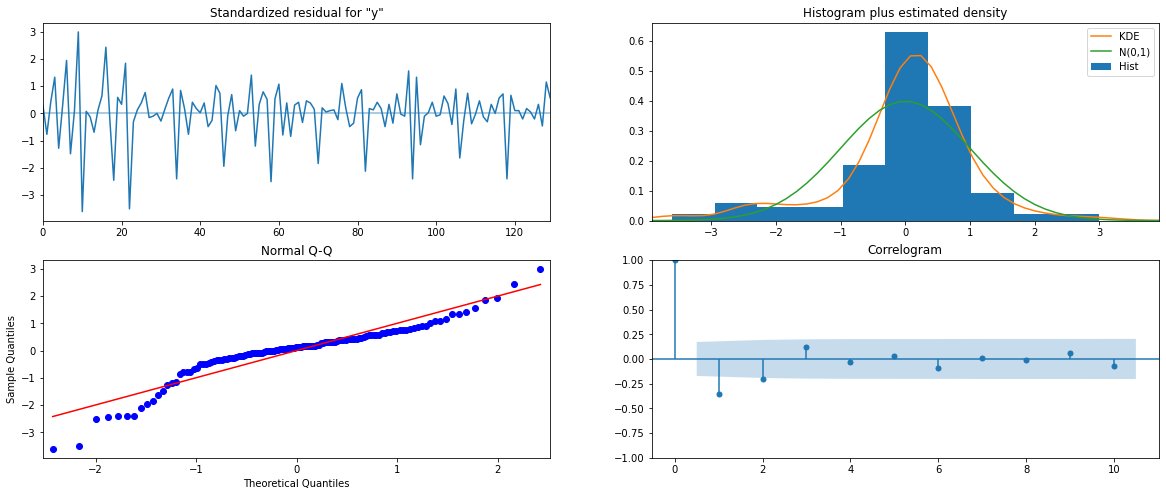

In [163]:
results_manual_SARIMA.plot_diagnostics()
plt.show()

In [164]:
# Predicting on the Test Set using this model and evaluate the model.

In [165]:
predicted_manual_SARIMA = results_manual_SARIMA.get_forecast(steps=len(test))

In [166]:
predicted_manual_SARIMA.summary_frame(alpha=0.05).head()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,132.0,39.077561,55.409388,208.590612
1,132.0,55.264017,23.684518,240.315482
2,132.0,67.684321,-0.658831,264.658831
3,132.0,78.155122,-21.181224,285.181224
4,132.0,87.380083,-39.261815,303.261815


In [167]:
rmse_manual_sarima = metrics.mean_squared_error(test['Rose'],predicted_manual_SARIMA.predicted_mean,squared=False)
print(rmse_manual_sarima)

79.73855004724103


In [168]:
results_m11 = pd.DataFrame({'Test RMSE': [rmse_manual_sarima]},
                          index=['pdq=(0,1,0),PDQS(0,0,0,12),SARIMA Manual'])

results_m11 = pd.concat([results_m10,results_m11])
results_m11

,Test RMSE
RegressionOnTime,15.275732
Naive Model,79.738550
Simple Average,53.480857
2pointTrailingMovingAverage,11.529409
4pointTrailingMovingAverage,14.455221
6pointTrailingMovingAverage,14.572009
9pointTrailingMovingAverage,14.731209
"Alpha=0.098,SimpleExponentialSmoothing-Autofit",36.816889
"Alpha=0.1,SimpleExponentialSmoothing",36.848694
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",36.900871


In [169]:
# Best  model as per RMSE test values

results_m11.sort_values(['Test RMSE'])

,Test RMSE
"Alpha=0.1,Beta=0.2,Gamma=0.2,TripleExponentialSmoothing",9.647756
2pointTrailingMovingAverage,11.529409
4pointTrailingMovingAverage,14.455221
6pointTrailingMovingAverage,14.572009
9pointTrailingMovingAverage,14.731209
RegressionOnTime,15.275732
"pdq=(3,1,1),PDQS=(3,1,1,12),SARIMA Automated",18.903315
"Alpha=0.06,Beta=0.05,Gamma=0.0,TripleExponentialSmoothing-Autofit",21.045505
"Alpha=0.098,SimpleExponentialSmoothing-Autofit",36.816889
"Alpha=2,Beta=1,Gamma=3,ARIMA Automated",36.838008


In [179]:
# Building the most optimum model on the Full Data.

In [180]:
model_TES_full = ExponentialSmoothing(df['Rose'],trend = 'add', seasonal='multiplicative')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [181]:
model_TES_fullmodel = model_TES_full.fit(smoothing_level=0.1,smoothing_slope=0.2,smoothing_seasonal=0.2,optimized=True,use_brute=True)

In [182]:
model_TES_fullmodel.params

{'smoothing_level': 0.1,
 'smoothing_trend': 0.2,
 'smoothing_seasonal': 0.2,
 'damping_trend': nan,
 'initial_level': 47.29786409429409,
 'initial_trend': 0.4819902632832751,
 'initial_seasons': array([2.37306015, 2.51107839, 2.7055196 , 2.31690871, 2.61407902,
        3.02841939, 3.38591421, 3.59736996, 3.22420445, 3.14265225,
        3.49151039, 5.08600889]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [183]:
# Evaluate the model on the whole and predict 12 months into the future.

In [184]:
TES_forecast = model_TES_fullmodel.forecast(steps=12)

In [207]:
TES_forecast

1995-08-31    47.427154
1995-09-30    48.269176
1995-10-31    50.273106
1995-11-30    58.463029
1995-12-31    82.124581
1996-01-31    31.701252
1996-02-29    39.442812
1996-03-31    45.376744
1996-04-30    46.826433
1996-05-31    40.738726
1996-06-30    47.021406
1996-07-31    53.990737
Freq: M, dtype: float64

In [208]:
TES_forecast.sum()

591.6551559795014

In [209]:
TES_forecast.mean()

49.30459633162513

In [210]:
TES_forecast.max()

82.1245811516889

Text(0.5, 1.0, 'Rose : 12 Months Forecast using TES Model')

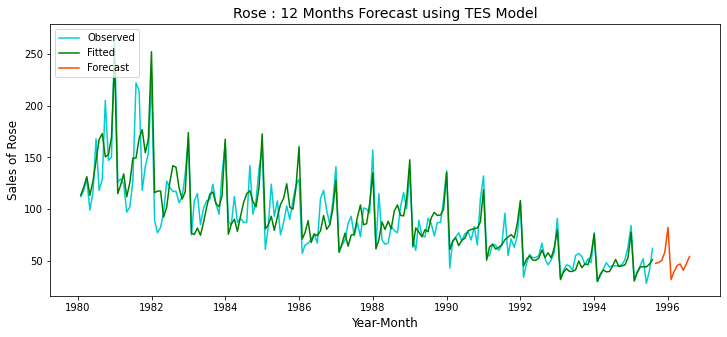

In [186]:
plt.figure(figsize=(12,5))

plt.plot(df['Rose'], label='Observed', color = 'darkturquoise')
plt.plot(model_TES_fullmodel.fittedvalues, label='Fitted', color = 'green')
plt.plot(TES_forecast, label='Forecast', color = 'orangered')
plt.legend(loc='upper left')
plt.xlabel('Year-Month',fontsize=12)
plt.ylabel('Sales of Rose',fontsize=12)
plt.title('Rose : 12 Months Forecast using TES Model', fontsize=14)

In [190]:
#In the below code, we have calculated the upper and lower confidence bands at 95% confidence level
#The percentile function under numpy lets us calculate these and adding and subtracting from the predictions
#gives us the necessary confidence bands for the predictions
pred_df = pd.DataFrame({'lower_ci':TES_forecast - 1.96*np.std(model_TES_fullmodel.resid,ddof=1),
                          'prediction':TES_forecast,
                          'upper_ci': TES_forecast + 1.96*np.std(model_TES_fullmodel.resid,ddof=1)})
pred_df.head()

,lower_ci,prediction,upper_ci
1995-08-31,13.238055,47.427154,81.616254
1995-09-30,14.080076,48.269176,82.458275
1995-10-31,16.084006,50.273106,84.462206
1995-11-30,24.273930,58.463029,92.652129
1995-12-31,47.935482,82.124581,116.313681


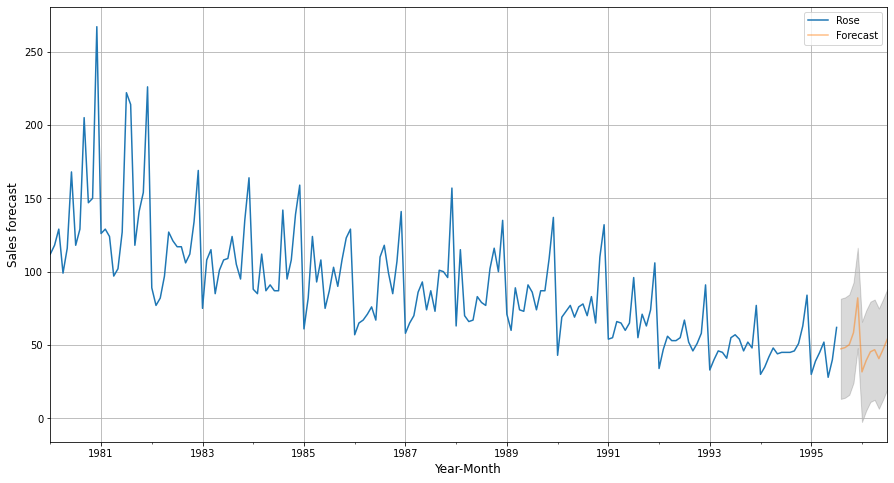

In [203]:
# plot the forecast along with the confidence band

axis = df.plot(label='Actual', figsize=(15,8))
pred_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_df.index, pred_df['lower_ci'], pred_df['upper_ci'], color='k', alpha=.15)
axis.set_xlabel('Year-Month',fontsize=12)
axis.set_ylabel('Sales forecast',fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

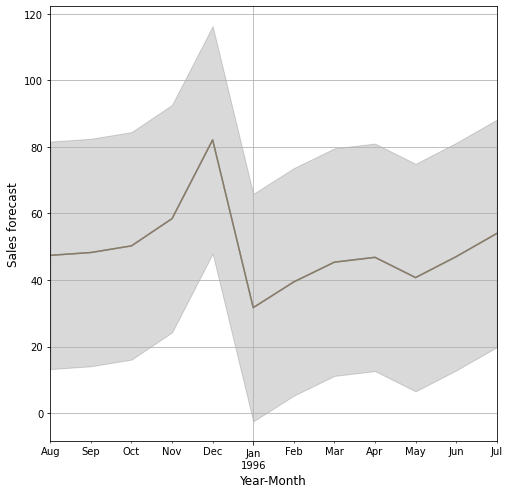

In [206]:
# plot the forecast along with the confidence band

axis = TES_forecast.plot(figsize=(8,8))
pred_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_df.index, pred_df['lower_ci'], pred_df['upper_ci'], color='k', alpha=.15)
axis.set_xlabel('Year-Month',fontsize=12)
axis.set_ylabel('Sales forecast',fontsize=12)
plt.grid()
plt.show()

In [ ]:
# END